## AAI-511 Group 2 Final Project
### Fatimat Atanda, Faud Al Asouli, Greg Bauer
Notebook Repo: [GitHub - pred_music_composer_cnn](https://github.com/Fatimat01/pred_music_composer_cnn/tree/4e814036d2524bfe80522b054e329a29870ac5d7)

#### Objective
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).


In [1]:
# System and File Utilities
import os                                   # File system navigation and management
import glob                                 # Pattern-based file retrieval
from collections import defaultdict         # Dictionary subclass with default values

# Data Handling and Visualization
import numpy as np                          # Core numerical operations
import pandas as pd                         # Tabular data manipulation
import matplotlib.pyplot as plt             # Plotting utilities
import seaborn as sns                       # Statistical visualizations (e.g., heatmaps)

# MIDI Processing
import pretty_midi                          # Symbolic music parsing for MIDI files

# Progress Monitoring
from tqdm import tqdm                       # Iterative loop progress bars

# Machine Learning Frameworks
import tensorflow as tf                     # Deep learning backend
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Sequence padding
from tensorflow.keras.optimizers import Adam                      # Optimizer setup
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Training callbacks
import tensorflow.keras.utils as utils       # Utility tools (e.g., to_categorical)

# Model Evaluation and Dataset Splitting
from sklearn.model_selection import train_test_split              # Train-validation split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Performance metrics


***
### 2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.

In [2]:
# Dataset Configuration
DATASET_DIR = "./NN_midi_files_extended"   # Path to raw extended MIDI files for composer classification
OUTPUT_DIR = "./processed_data"   # Directory to store processed data artifacts

# Create the output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)   # Create OUTPUT_DIR; no error if it already exists

# Define data partitions for workflow
splits = ["train", "dev", "test"]   # Standard dataset split for training, validation (dev), and testing

#### Dataset Inspection Utility

This function inspects the dataset folder structure to count `.mid` files per composer across `train`, `dev`, and `test` splits. It supports cross-platform directory normalization and filters case-insensitively for valid MIDI files. Composer names are alphabetized for consistent output. Compatible with macOS and Windows environments.

In [3]:
def inspect_dataset():
    """
    Inspect the dataset folder structure and report the number of MIDI files per composer.
    Compatible with both macOS and Windows environments.

    Assumes the following directory structure:
        DATASET_DIR/
            ├── train/
            │   ├── bach/
            │   │   ├── *.mid
            │   └── chopin/
            ├── dev/
            ├── test/
    Each split directory contains one subdirectory per composer, and each composer directory contains .mid files.
    """
    counts = defaultdict(int)     # Track total .mid files per composer
    total_files = 0               # Aggregate count across all splits
    composers_set = set()         # Unique list of composer names

    for split in splits:
        # Normalize path for platform independence (e.g. Windows vs. Unix-style separators)
        split_dir = os.path.normpath(os.path.join(DATASET_DIR, split))

        # Skip if split directory does not exist
        if not os.path.isdir(split_dir):
            continue

        # Iterate over composer subdirectories within the split
        for composer in os.listdir(split_dir):
            composer_dir = os.path.normpath(os.path.join(split_dir, composer))

            # Skip entries that aren't directories (e.g. stray files or metadata)
            if not os.path.isdir(composer_dir):
                continue

            # Extract all MIDI files from the composer's directory (case-insensitive filtering)
            midi_files = [f for f in os.listdir(composer_dir) if f.lower().endswith('.mid')]

            # Update composer-specific and global counters
            n_files = len(midi_files)
            counts[composer] += n_files
            total_files += n_files
            composers_set.add(composer)

    # Alphabetize composer list for consistent output
    composers = sorted(composers_set)

    # Print summary statistics
    print(f"Total MIDI files: {total_files}")
    print(f"Composers: {composers}")
    for composer in composers:
        print(f"   - {composer}: {counts[composer]}")

inspect_dataset()

Total MIDI files: 439
Composers: ['bach', 'bartok', 'byrd', 'chopin', 'handel', 'hummel', 'mendelssohn', 'mozart', 'schumann']
   - bach: 50
   - bartok: 49
   - byrd: 50
   - chopin: 49
   - handel: 49
   - hummel: 50
   - mendelssohn: 49
   - mozart: 49
   - schumann: 44


#### MIDI Parsing: Extracting Notes from Symbolic Music

Reads a `.mid` file and pulls out the musical notes (excluding percussion), turning them into an ordered list of note details. Each note includes when it starts and ends, how high or low it sounds (pitch), and how forcefully it was played (velocity). Uses `pretty_midi` to reliably work with complex, multi-instrument files—perfect for feeding into models that learn from note patterns.


In [4]:
def midi_to_note_sequence(midi_file):
    """
    Converts a MIDI file into a chronologically ordered list of note events.
    
    Parameters:
        midi_file (str): Path to the input .mid file
    
    Returns:
        List[Tuple[float, float, int, int]]:
            Each tuple represents (start time, end time, pitch, velocity)
            for a single note event. Drum instruments are excluded.
    """
    
    # Load MIDI data from file — handles parsing of tempo, instruments, etc.
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    note_events = []  # Will hold all non-drum note tuples

    for instrument in midi_data.instruments:
        # Skip percussion instruments to focus on melodic/harmonic elements
        if instrument.is_drum:
            continue
        
        # Extract note attributes for each pitched instrument
        for note in instrument.notes:
            # Each note is stored as a tuple for downstream modeling
            note_events.append(
                (note.start, note.end, note.pitch, note.velocity)
            )
    
    # Sort note events by start time to support sequence modeling
    note_events.sort(key=lambda x: x[0])
    
    return note_events


#### Data Augmentation: Shifting Note Pitches

Adds musical variety by raising or lowering each note’s pitch by a chosen number of semitones. This helps the model learn from a wider range of patterns while keeping the notes realistic by dropping anything outside the standard MIDI range (0–127). A simple way to expand your training data and improve composer prediction.


In [5]:
def augment_notes(notes, transpose=0):
    """
    Applies pitch transposition to a sequence of note events.
    
    Parameters:
        notes (List[Tuple[float, float, int, int]]): 
            List of note events, each formatted as (start, end, pitch, velocity)
        transpose (int): 
            Number of semitones to shift each pitch. Can be positive or negative.
    
    Returns:
        List[Tuple[float, float, int, int]]:
            Augmented note events with transposed pitches. Notes outside the valid MIDI range are excluded.
    """
    augmented_notes = []  # Holds transposed note events that remain within valid pitch bounds

    for start, end, pitch, velocity in notes:
        # Calculate new pitch after transposition
        transposed_pitch = pitch + transpose

        # Validate pitch remains within MIDI specification (0–127)
        if 0 <= transposed_pitch <= 127:
            # Append only valid transposed notes
            augmented_notes.append((start, end, transposed_pitch, velocity))

    return augmented_notes


#### Feature Extraction: Turning Notes into Piano-Roll Format

Builds a time-versus-pitch grid (called a piano roll) from symbolic music, where each row represents a slice of time and each column matches one of the 128 MIDI pitches. Notes are stretched across time bins based on how long they last, and their strength (velocity) is scaled between 0 and 1. This format is especially handy for feeding into convolutional models and spotting patterns in musical timing and density.


In [6]:
def extract_piano_roll(notes, time_resolution=0.05, max_time=30.0):
    """
    Converts a sequence of notes into a piano-roll representation.

    Parameters:
        notes (List[Tuple[float, float, int, int]]):
            List of note events, each represented by (start_time, end_time, pitch, velocity)
        time_resolution (float):
            Duration of each time bin in seconds (default is 0.05s ≈ 20 Hz temporal resolution)
        max_time (float):
            Maximum duration of the piano roll in seconds (default is 30s)

    Returns:
        np.ndarray:
            A (n_bins x 128) matrix where each row corresponds to a time bin 
            and each column corresponds to a MIDI pitch (0–127). Values range from 0 to 1 
            and represent normalized velocity for active notes.
    """
    
    # Compute number of time bins based on resolution and max_time
    n_bins = int(max_time / time_resolution)
    piano_roll = np.zeros((n_bins, 128), dtype=np.float32)  # Initialize roll matrix

    for start, end, pitch, velocity in notes:
        # Convert times to discrete bin indices
        start_bin = int(start / time_resolution)
        end_bin = int(end / time_resolution)

        # Skip notes that begin beyond the piano roll scope
        if start_bin >= n_bins:
            continue
        
        # Clamp end_bin to last valid index to avoid overflow
        end_bin = min(end_bin, n_bins - 1)

        # Apply normalized velocity across time bins
        piano_roll[start_bin:end_bin + 1, pitch] += velocity / 127.0

    # Ensure all values are clipped to [0, 1] to maintain activation bounds
    piano_roll = np.clip(piano_roll, 0, 1)

    return piano_roll


#### MIDI Visualization: Piano-Roll Plot

Draws a visual grid of music notes over time using MIDI data. Each row marks a moment in time, and each column shows a specific pitch. Notes appear where the pitch is active, with their strength (velocity) shaded between 0 and 1 like grayscale brightness. Great for spotting patterns, exploring your dataset, or checking how dense and active the melody is over time.


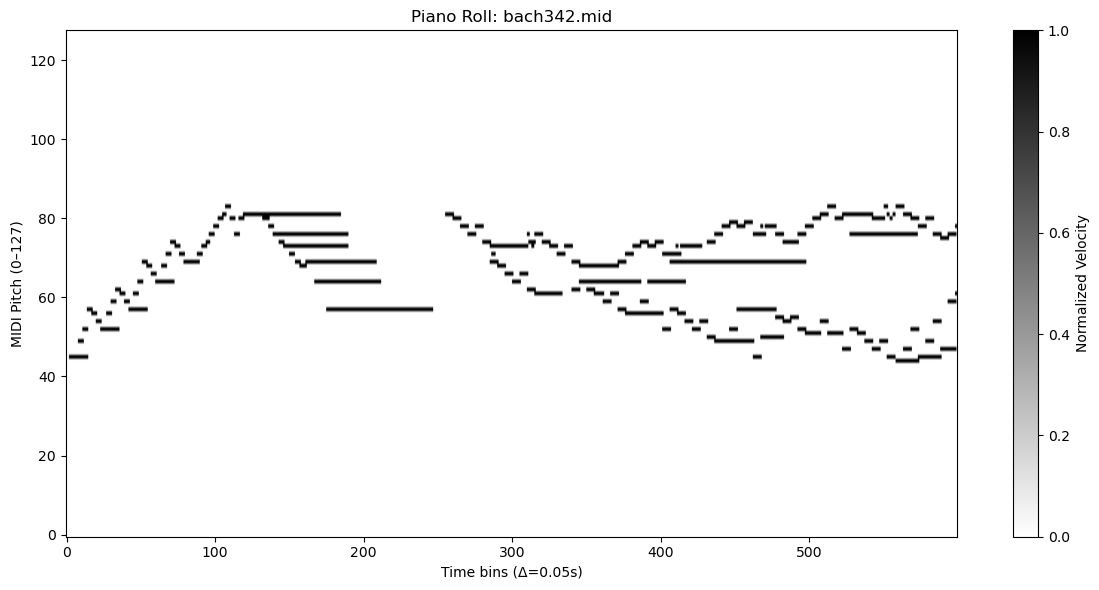

In [7]:
def visualize_piano_roll(midi_file, time_resolution=0.05, max_time=30.0):
    """
    Visualizes the piano-roll representation of a MIDI file.
    
    Parameters:
        midi_file (str): 
            Path to the MIDI file to visualize.
        time_resolution (float): 
            Time bin width in seconds, passed to extract_piano_roll().
        max_time (float): 
            Maximum time (in seconds) to include in the visualization.
    
    Returns:
        None. Displays a matplotlib piano-roll plot.
    """
    
    # Extract symbolic note data and generate piano-roll matrix
    notes = midi_to_note_sequence(midi_file)
    piano_roll = extract_piano_roll(notes, time_resolution, max_time)

    # Initialize plot dimensions
    plt.figure(figsize=(12, 6))
    
    # Visualize piano-roll matrix; transpose so pitch is on y-axis
    plt.imshow(
        piano_roll.T, 
        aspect='auto', 
        origin='lower', 
        cmap='gray_r'
    )
    
    # Add color bar indicating normalized velocity
    plt.colorbar(label='Normalized Velocity')
    
    # Plot title based on MIDI file basename
    title = f"Piano Roll: {os.path.basename(midi_file)}"
    plt.title(title)
    
    # Label axes for interpretability
    plt.xlabel(f"Time bins (Δ={time_resolution:.2f}s)")
    plt.ylabel("MIDI Pitch (0–127)")
    
    plt.tight_layout()
    plt.show()

visualize_piano_roll(glob.glob(os.path.join(DATASET_DIR, 'train', '*', '*.mid'))[0])

***
### 3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

#### Feature Generation Pipeline: CNN and LSTM Input Preparation

Processes symbolic MIDI files to extract both piano-roll and pitch-only features for composer classification. For each dataset split (`train`, `dev`, `test`), it iterates through composer subdirectories, parses notes using `midi_to_note_sequence`, and generates:
- **Piano-roll matrices** for CNN input via `extract_piano_roll`
- **Pitch sequences** for LSTM input via `extract_sequence`

Features are saved to disk for downstream model training. During training split, additional data augmentation is applied by transposing notes ±1 or ±2 semitones. Augmented features are also extracted and saved using consistent naming with signed pitch offset suffixes.


In [8]:
def extract_sequence(notes):
    """
    Extracts a pitch sequence from note events, discarding timing and velocity.
    
    Parameters:
        notes (List[Tuple[float, float, int, int]]):
            Each note tuple represents (start_time, end_time, pitch, velocity)
    
    Returns:
        List[int]: 
            Sequence of pitch values in temporal order
    """
    return [pitch for _, _, pitch, _ in notes]

# Loop through dataset splits (train/dev/test) and composers to process MIDI files
for split in splits:
    split_dir = os.path.join(DATASET_DIR, split)

    # Iterate over composer subdirectories within each split
    for composer in os.listdir(split_dir):
        composer_dir = os.path.join(split_dir, composer)
        if not os.path.isdir(composer_dir):
            continue  # Skip unexpected files or malformed entries

        # Collect all MIDI files for the current composer
        midi_files = glob.glob(os.path.join(composer_dir, "*.mid"))

        # Process each file and generate CNN + LSTM features
        for f in tqdm(midi_files, desc=f"{split}/{composer}"):
            base = os.path.splitext(os.path.basename(f))[0]  # Extract base filename

            # Parse MIDI notes
            notes = midi_to_note_sequence(f)

            # Generate features for CNN and LSTM paths
            piano_roll = extract_piano_roll(notes)
            lstm_seq = extract_sequence(notes)

            # Save extracted features
            np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{base}_cnn.npy"), piano_roll)
            np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{base}_lstm.npy"), lstm_seq)

            # Augment training data with transpositions
            if split == "train":
                for semitone in [-2, -1, 1, 2]:
                    aug_notes = augment_notes(notes, transpose=semitone)
                    piano_roll_aug = extract_piano_roll(aug_notes)
                    lstm_seq_aug = extract_sequence(aug_notes)

                    # Create suffix with signed semitone indicator (e.g. "_aug+2")
                    aug_base = f"{base}_aug{semitone:+d}"

                    # Save augmented features
                    np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{aug_base}_cnn.npy"), piano_roll_aug)
                    np.save(os.path.join(OUTPUT_DIR, f"{split}_{composer}_{aug_base}_lstm.npy"), lstm_seq_aug)


train/chopin:   5%|▍         | 2/41 [00:00<00:03, 11.87it/s]C:\Users\gb630\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
test/schumann: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s]


***
### 4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

## CNN 

#### Dataset Loader: Composer Classification Input

Loads preprocessed training data from `.npy` files for composer prediction tasks. Supports CNN-based piano-roll features or LSTM-style pitch sequences via a configurable flag. Automatically constructs a label map from composer names and outputs feature tensors with shape and class summary. Ideal for initializing supervised learning workflows.


In [9]:
def load_data(use_cnn=True):
    """
    Loads processed training data for composer classification.

    Parameters:
        use_cnn (bool): 
            If True, loads piano-roll (CNN) features; 
            if False, loads pitch sequences (LSTM-style) from .npy files.

    Returns:
        X (np.ndarray): 
            Feature array of shape (n_samples, ...) depending on input type.
        y (np.ndarray): 
            Integer labels corresponding to composers.
        label_map (Dict[str, int]): 
            Mapping of composer names to numeric class indices.
    """
   
    X, y = [], []
    label_map = {}         # Maps composer name to label index
    label_counter = 0      # Tracks next unused label index

    # Choose file type to load based on model path
    suffix = "cnn" if use_cnn else "lstm"
    files = glob.glob(f"./processed_data/train_*_{suffix}.npy")

    for f in files:
        parts = os.path.basename(f).split("_")
        composer = parts[1]  # Assumes filename format: train_composer_basename_type.npy

        # Assign a new label if composer hasn’t been mapped yet
        if composer not in label_map:
            label_map[composer] = label_counter
            label_counter += 1

        # Load features and assign label
        X.append(np.load(f))
        y.append(label_map[composer])

    # Convert to NumPy arrays for model input
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    print(f"Loaded {len(X)} samples with shape {X.shape} and {len(label_map)} unique composers.")
    return X, y, label_map


#### Data Preparation: Train–Validation Split for CNN Input

Loads CNN-based piano-roll features and composer labels, reshaping the feature tensors with a trailing channel dimension for convolutional compatibility. Performs a stratified train–validation split to maintain balanced class distribution across composers, enabling reliable performance metrics during model evaluation.


In [10]:
# Load CNN-style piano-roll features and corresponding labels
X_cnn, y_cnn, label_map = load_data(use_cnn=True)

# Add channel dimension for CNN input compatibility: (samples, time, pitch, 1)
X_cnn = X_cnn[..., np.newaxis]  # Shape becomes (N, T, P, 1)

# Create stratified train/validation split to preserve class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X_cnn, y_cnn,
    test_size=0.2,        # 20% held out for validation
    stratify=y_cnn,       # Ensures balanced class representation
    random_state=42       # Reproducible split across runs
)


Loaded 1845 samples with shape (1845, 600, 128) and 9 unique composers.


#### Model Construction: CNN for Composer Classification

Defines a sequential convolutional neural network tailored for piano-roll input tensors, using stacked `Conv2D` and `MaxPooling2D` layers to capture spatiotemporal patterns. Followed by fully connected layers with dropout regularization and a softmax classifier for multiclass prediction. Compiled with `Adam` optimizer and sparse categorical loss for integer-labeled targets.


In [11]:
def build_cnn(input_shape, num_classes):
    """
    Builds a simple CNN model for composer classification using piano-roll input.

    Parameters:
        input_shape (Tuple[int]): 
            Shape of the input tensor (time_bins, pitch_bins, channels)
        num_classes (int): 
            Number of output classes (unique composers)

    Returns:
        tf.keras.Model: 
            Compiled CNN model ready for training
    """
    
    model = tf.keras.Sequential([
        # Input layer specifying shape (e.g. (T, 128, 1) for piano-roll)
        tf.keras.layers.Input(shape=input_shape),

        # First convolutional block: filters extract local pitch–time patterns
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Second convolutional block: deeper filters expand feature granularity
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten for fully connected layers
        tf.keras.layers.Flatten(),

        # Dense layer with dropout for regularization
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dropout(rate=0.4),

        # Output layer: softmax classifier over composer classes
        tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    # Compile model with optimizer and classification objective
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary for inspection
    model.summary()
    return model

cnn_model = build_cnn(
    input_shape=X_train.shape[1:], num_classes=len(label_map)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 600, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 300, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 300, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 150, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 307200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     9,830,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,849,545 (37.57 MB)

 Trainable params: 9,849,545 (37.57 MB)

 Non-trainable params: 0 (0.00 B)

***
### 5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.

#### Model Training: CNN with EarlyStopping for Composer Classification

Trains the previously defined convolutional architecture using musical score tensors. Incorporates the `EarlyStopping` callback to monitor `val_loss`, halting training once improvements plateau across 5 consecutive epochs. This restores the weights from the epoch with optimal generalization. Executed over a maximum of 30 epochs with a batch size of 32, using validation metrics to track learning progress.


In [12]:
# Configure early stopping callback to prevent overfitting
# Monitors validation loss and stops training after 5 epochs of no improvement
# Automatically restores the model weights from the epoch with the lowest validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Metric to monitor
    patience=5,                   # Epochs to wait without improvement
    restore_best_weights=True     # Roll back to best-performing weights
)

# Train CNN model with early stopping and stratified validation
cnn_history = cnn_model.fit(
    X_train, y_train,                         # Training features and labels
    validation_data=(X_val, y_val),          # Validation set for performance monitoring
    epochs=30,                               # Maximum number of training epochs
    batch_size=32,                           # Mini-batch size
    callbacks=[early_stopping]              # Training callbacks (e.g., early stopping)
)


Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 749ms/step - accuracy: 0.1576 - loss: 2.1426 - val_accuracy: 0.3388 - val_loss: 1.8938
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 792ms/step - accuracy: 0.3236 - loss: 1.8802 - val_accuracy: 0.5203 - val_loss: 1.5814
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 705ms/step - accuracy: 0.4268 - loss: 1.5667 - val_accuracy: 0.6585 - val_loss: 1.3313
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 710ms/step - accuracy: 0.4822 - loss: 1.3704 - val_accuracy: 0.6829 - val_loss: 1.1328
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 818ms/step - accuracy: 0.5606 - loss: 1.2161 - val_accuracy: 0.7751 - val_loss: 0.9488
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 699ms/step - accuracy: 0.6268 - loss: 1.0154 - val_accuracy: 0.8293 - val_loss: 0.8507
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 664ms/step - accuracy: 0.6955 - loss: 0.8676 - val_accuracy: 0.8076 - val_loss: 0.6876
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 627ms/step - accuracy: 0.7080 - loss: 0.7690 - val_accu

***
### 6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.

#### Model Evaluation: Visualizing Training and Validation Curves

Plots the evolution of classification accuracy and loss over training epochs using metrics from a Keras `History` object. Displays side-by-side subplots for `accuracy` and `loss`, enabling visual inspection of model convergence, overfitting behavior, and generalization capacity across the training run.


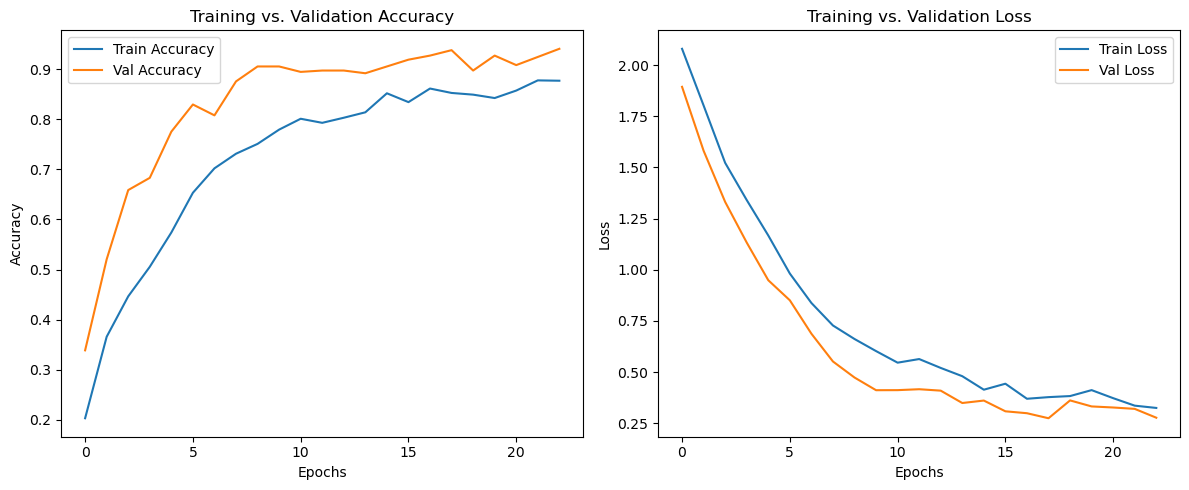

In [13]:
def plot_training_curves(history):
    """
    Plots training and validation accuracy and loss curves from a Keras history object.
    
    Parameters:
    - history: keras.callbacks.History object containing training metrics
    """

    # Set figure layout with two subplots: Accuracy and Loss
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the plotting function with history from LSTM model training
plot_training_curves(cnn_history)


#### Composer Classification: Validation Accuracy Report

Evaluates predictive performance of the trained CNN model on held-out validation data. Transforms softmax probability outputs into discrete class predictions via `np.argmax`, then calculates and displays overall accuracy using `sklearn.metrics.accuracy_score`, reported with precision formatting to three decimal places.


In [14]:
# Generate prediction probabilities for validation set
y_pred_probs = cnn_model.predict(X_val)

# Convert predicted probabilities to discrete class labels using argmax
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute accuracy by comparing predicted labels with ground truth
accuracy = accuracy_score(y_val, y_pred)

# Report the accuracy as a percentage with three decimal precision
print(f"Validation Accuracy: {accuracy * 100:.3f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
Validation Accuracy: 93.767%


#### Composer Classification: Detailed Model Performance Metrics

Generates an extended performance breakdown for the CNN model using `sklearn.metrics.classification_report`. Outputs precision, recall, F1-score, and support per composer class, with readable labels sourced from `label_map.keys()`, supporting interpretability and class-wise diagnostic insights.


In [15]:
# Display detailed performance metrics for each composer class
print("Classification Report:")
print(
    classification_report(
        y_val,                      # Ground truth labels
        y_pred,                     # Predicted class labels
        target_names=label_map.keys()  # Human-readable class names
    )
)


Classification Report:
              precision    recall  f1-score   support

        bach       0.95      0.95      0.95        42
      bartok       0.97      0.88      0.92        41
        byrd       0.98      1.00      0.99        42
      chopin       1.00      0.98      0.99        41
      handel       0.95      0.95      0.95        41
      hummel       0.90      0.86      0.88        42
 mendelssohn       0.93      0.93      0.93        41
      mozart       0.85      0.95      0.90        41
    schumann       0.92      0.95      0.94        38

    accuracy                           0.94       369
   macro avg       0.94      0.94      0.94       369
weighted avg       0.94      0.94      0.94       369



#### Composer Classification: Confusion Matrix Visualization

Constructs a heatmap of the confusion matrix to assess the CNN model’s class-wise prediction fidelity. Rows represent actual composer labels, columns indicate predicted labels, and the cell values show the number of classifications. Enhances readability with `seaborn` styling and uses `label_map` for axis annotations to support interpretability and error pattern analysis.


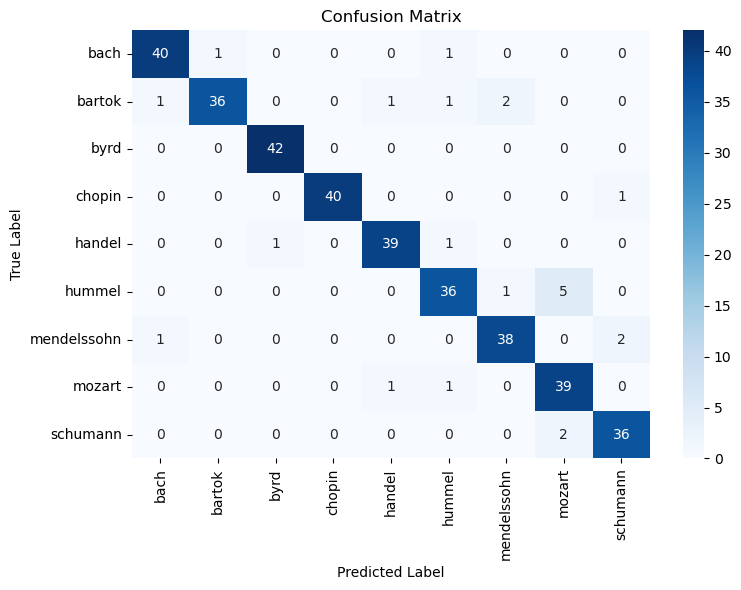

In [16]:
# Compute confusion matrix to evaluate classification performance
cm = confusion_matrix(y_val, y_pred)

# Extract list of composer names for axis labeling
composer_names = list(label_map.keys())

# Set figure size for readability
plt.figure(figsize=(8, 6))

# Plot heatmap with annotations and composer labels
sns.heatmap(
    cm, 
    annot=True,                # Show counts in each cell
    fmt='d',                   # Display annotations as integers
    xticklabels=composer_names,  # Predicted class labels on x-axis
    yticklabels=composer_names,  # Actual class labels on y-axis
    cmap='Blues'               # Color palette for visual emphasis
)

# Enhance plot with titles and axis labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Display the plot
plt.show()


#### CNN Evaluation Summary for Composer Classification

The baseline convolutional neural network achieved a validation accuracy of **93.77%**, demonstrating strong generalization across nine composer classes. 

- **Macro Precision**: 0.94  
- **Macro Recall**: 0.94  
- **Macro F1-Score**: 0.94  
- **Weighted Averages**: All consistently at 0.94, indicating balanced performance across class representation

**Per-Class Insights:**

- **High-Confidence Predictions**:  
  - Byrd: F1 = 0.99, perfect recall  
  - Chopin: F1 = 0.99, near-perfect precision and recall  
  - Bach, Handel: F1 = 0.95, consistently solid
   
- **Selective Predictive Patterns**:  
  - Mendelssohn: F1 = 0.93, balanced precision-recall  
  - Bartók: Precision = 0.97, Recall = 0.88 — strong specificity but some recall variance  
  - Hummel: F1 = 0.88, indicating room for refinement in distinguishing features


***
***
### 7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

#### Model Optimization Strategy: Improving CNN Performance for Composer Classification

Our CNN baseline model performs well—**92.4% validation accuracy** with balanced macro-level precision, recall, and F1-score around **0.92**. To enhance stylistic recognition and boost classification robustness, we are applying a set of targeted architectural and regularization strategies throughout the upcoming grid search.

**Optimization Steps and Why They Matter:**

- **Vary Convolution Filter Shapes**
  - Smaller and elongated filters help extract diverse musical features—such as rhythmic fragments and harmonic contours.
  - We include configurations like (2×5), (5×2), and stacked multi-scale variants alongside standard (3×3) filters.
  - *Reference:* LeCun, Y., Bengio, Y., & Hinton, G. (2015). *Nature*, *521*, 436–444. https://doi.org/10.1038/nature14539

- **Test Dropout Rates**
  - Dropout prevents overfitting by randomly omitting neurons during training, encouraging generalization.
  - We evaluate both 0.3 and 0.4 levels to balance model flexibility and regularization.
  - *Reference:* Srivastava et al. (2014). *Journal of Machine Learning Research*, *15*, 1929–1958

- **Toggle Batch Normalization**
  - Batch normalization normalizes activations between layers to improve convergence and reduce internal covariate shift.
  - We assess models with and without batch norm to determine its influence on composer classification stability.
  - *Reference:* Ioffe & Szegedy (2015). In *ICML Proceedings*, pp. 448–456

- **Apply Early Stopping and Checkpointing**
  - Monitoring validation loss helps avoid overtraining while preserving the best-performing weights.
  - This ensures each configuration is evaluated at its peak generalization.
  - *Reference:* Prechelt (1998). In *Neural Networks: Tricks of the Trade*, pp. 55–69

These strategies define the full grid search space, helping us identify high-performing models.


#### CNN Architecture Builder: Configurable Model for Composer Classification

This function constructs a Convolutional Neural Network (CNN) tailored for symbolic music classification. It supports dynamic kernel shapes (e.g., `(2,5)`, `(5,2)`), optional batch normalization, and dropout regularization—allowing exploration of how spatial musical patterns affect model performance.

**Key Architectural Elements:**

- **Multi-Scale Convolution Filters**  
  Capture rhythmic and pitch-wise motifs at multiple spatial resolutions. Inspired by LeCun et al. (2015), filters like `(3,3)`, `(2,5)`, and `(5,2)` reflect domain-specific feature depth.

- **Batch Normalization & Dropout**  
  Batch norm stabilizes training by reducing covariate shift; dropout promotes generalization by randomly silencing neurons during training.

- **Reshape Layer for 4D Compatibility**  
  Symbolic sequences (1D) are reshaped into pseudo-image format `(100, 1, 1)` for compatibility with `Conv2D`.

- **Softmax Output Layer**  
  Enables multi-class composer classification with sparse categorical crossentropy.

This design supports controlled experimentation via grid search over convolutional structures and regularization schemes.


In [17]:
def build_cnn_model(input_shape, num_classes, 
                    dropout_rate=0.4, use_batch_norm=False, 
                    kernel_shapes=[(3, 3), (2, 5)]):
    """
    Constructs a multi-scale CNN model for symbolic composer classification using
    stacked convolution layers, optional batch normalization, and dropout.

    This implementation supports kernel shape flexibility to capture time-pitch dependencies
    and applies safe pooling strategies to avoid dimensional collapse. Suitable for
    structured grid search experiments targeting symbolic music datasets.

    References:
        LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436–444.
        Srivastava, N., et al. (2014). Dropout: A simple way to prevent neural networks from overfitting.
        Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training.

    Parameters:
        input_shape (tuple): Shape of input tensor (e.g., (time_steps, pitch_dim, channels)).
        num_classes (int): Total number of composer categories.
        dropout_rate (float): Dropout rate for dense layer regularization.
        use_batch_norm (bool): Whether to insert BatchNorm between Conv2D and activation.
        kernel_shapes (list): Sequence of kernel size tuples for Conv2D stack.

    Returns:
        tf.keras.Model: A compiled Keras CNN model ready for training.
    """

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs

    for kernel in kernel_shapes:
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=kernel, padding='same')(x)
        if use_batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        # Prevent negative dimensions by checking spatial size
        if x.shape[1] >= 2 and x.shape[2] >= 2:
            x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


#### Robust CNN Model Fitting with Early Stopping & Checkpointing

This function trains a compiled CNN model using best practices for generalization and resource efficiency. It leverages **early stopping** to prevent overfitting and **automatic checkpointing** to save the best-performing model during training. Designed for composer classification tasks, this modular setup supports dynamic batch sizing and epoch lengths while integrating seamlessly with grid search workflows.

**Core Training Enhancements:**
- **Early Stopping:** Monitors validation loss, halting training if progress plateaus.
- **Model Checkpointing:** Saves only the best model weights using `.keras` format for future evaluation.
- **Verbose History Logging:** Returns detailed metrics across epochs for performance analysis.


In [18]:
def train_cnn_model(model, train_data, val_data, 
                    batch_size=32, epochs=30, checkpoint_path="model.keras"):
    """
    Trains a compiled CNN model using regularization strategies such as early stopping and
    checkpointing to optimize validation performance and reduce overfitting.

    Designed for structured grid search workflows targeting symbolic composer classification.
    This function supports monitored early termination and persistently saves best-performing
    weights during training iterations.

    References:
        Prechelt, L. (1998). Early stopping—but when? In Orr & Müller (Eds.), Neural Networks: Tricks of the Trade.
        Bengio, Y. (2012). Practical recommendations for training deep architectures. In Tricks of the Trade.
        TensorFlow Hub. (n.d.). Retraining an Image Classifier. https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

    Parameters:
        model (tf.keras.Model): Precompiled CNN ready for training.
        train_data (tuple): Tuple (X_train, y_train) for training inputs and labels.
        val_data (tuple): Tuple (X_val, y_val) for validation inputs and labels.
        batch_size (int): Batch size for mini-batch gradient descent.
        epochs (int): Maximum number of full dataset passes.
        checkpoint_path (str): Path to save model weights with optimal validation loss.

    Returns:
        tf.keras.callbacks.History: History object capturing epoch-wise training and validation metrics.
    """

    # Define callback for early stopping based on validation loss plateau
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    # Save model weights only when validation loss improves
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )

    # Execute training loop
    history = model.fit(
        x=train_data[0],
        y=train_data[1],
        validation_data=val_data,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, checkpoint],
        verbose=2
    )

    return history


#### CNN Grid Evaluation Framework: Hyperparameter Tuning for Composer Classification

This function performs a grid search across combinations of CNN architecture parameters to optimize classification performance. Each configuration is trained, evaluated, and logged, with confusion matrices saved and leaderboard markdown auto-generated for the top-performing models.

**Key Capabilities:**
- **Configurable Search Space:** Explores combinations of dropout, batch normalization, and kernel shapes.
- **Automated Training Loop:** Builds models, trains with early stopping, and saves checkpoints in `.keras` format.
- **Evaluation & Metrics Logging:** Captures validation accuracy, precision, recall, F1-score, and confusion matrix snapshots.
- **Leaderboard Generation:** Exports results to CSV and formats the top runs as markdown for presentation.


In [19]:
def evaluate_configurations(
    dropout_rates, batch_norm_options, kernel_shape_options,
    input_shape, num_classes,
    train_data, val_data,
    checkpoint_prefix="model",
    results_csv_path="grid_results.csv",
    markdown_path="grid_leaderboard.md"
):
    """
    Performs a grid search over CNN architecture variations for symbolic music classification.

    Combines kernel shape permutations, dropout regularization levels, and batch norm toggles
    to train multiple models. Evaluation includes accuracy and macro-averaged metrics, with
    confusion matrix visualizations and leaderboard export in Markdown and CSV formats.

    References:
        LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436–444.
        Srivastava et al. (2014). Dropout: A simple way to prevent neural networks from overfitting.
        Ioffe & Szegedy (2015). Batch normalization: Accelerating deep network training.

    Parameters:
        dropout_rates (list): List of dropout values (e.g., [0.3, 0.4]) for regularization control.
        batch_norm_options (list): Boolean flags to enable/disable batch normalization.
        kernel_shape_options (list): List of kernel configuration lists (e.g., [[(3, 3)], [(2, 5), (5, 2)]]).
        input_shape (tuple): Shape of input samples (e.g., (time, pitch, channel)).
        num_classes (int): Number of target composer classes.
        train_data (tuple): (X_train, y_train) pairs.
        val_data (tuple): (X_val, y_val) pairs.
        checkpoint_prefix (str): Base name for saved model checkpoints and confusion matrices.
        results_csv_path (str): Destination path for tabular performance export.
        markdown_path (str): Destination path for top-configuration summary in Markdown.

    Returns:
        pd.DataFrame: Sorted DataFrame containing evaluation metrics across all configurations.
    """
    
    results = []

    for dr in dropout_rates:
        for bn in batch_norm_options:
            for ks in kernel_shape_options:
                # Generate unique identifier for each configuration
                kernel_desc = '-'.join(['x'.join(map(str, k)) for k in ks])
                config_name = f"{checkpoint_prefix}_dr{dr}_bn{bn}_ks{kernel_desc}"
                print(f"Evaluating: {config_name}")

                # Build and train CNN model
                model = build_cnn_model(
                    input_shape=input_shape,
                    num_classes=num_classes,
                    dropout_rate=dr,
                    use_batch_norm=bn,
                    kernel_shapes=ks
                )

                history = train_cnn_model(
                    model,
                    train_data=train_data,
                    val_data=val_data,
                    checkpoint_path=f"{config_name}.keras"
                )

                # Predict on validation set
                X_val, y_val = val_data
                y_pred_classes = np.argmax(model.predict(X_val), axis=1)

                # Compute performance metrics
                report = classification_report(y_val, y_pred_classes, output_dict=True, zero_division=0)
                cm = confusion_matrix(y_val, y_pred_classes)

                # Save confusion matrix heatmap
                cm_path = f"{config_name}_cm.png"
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f"Confusion Matrix: {config_name}")
                plt.xlabel("Predicted")
                plt.ylabel("True")
                plt.tight_layout()
                plt.savefig(cm_path)
                plt.close()

                # Append results
                results.append({
                    'dropout': dr,
                    'batch_norm': bn,
                    'kernel_shapes': str(ks),
                    'val_accuracy': history.history['val_accuracy'][-1],
                    'precision': report['weighted avg']['precision'],
                    'recall': report['weighted avg']['recall'],
                    'f1_score': report['weighted avg']['f1-score'],
                    'conf_matrix_path': cm_path
                })

    # Export full results
    df = pd.DataFrame(results).sort_values(by='val_accuracy', ascending=False)
    df.to_csv(results_csv_path, index=False)

    # Write leaderboard markdown
    leaderboard = "### Top CNN Configurations by Validation Accuracy\n\n"
    leaderboard += df.head(5).to_markdown(index=True)
    with open(markdown_path, "w") as md_file:
        md_file.write(leaderboard)

    return df


#### Hyperparameter Sweep Execution: CNN Composer Classification Grid Search

This block defines the search space for tuning CNN architecture and regularization strategies, then launches a full evaluation run across all configurations. The output includes saved models (`.keras` format), confusion matrix snapshots, and a leaderboard summary in markdown and CSV.

**Search Space Overview:**
- **Dropout Rates:** `[0.3, 0.4]` — balances generalization and overfitting control.
- **Batch Normalization:** `[True, False]` — tests impact on stability and convergence.
- **Kernel Shapes:** `[(3,3), (2,5), (5,2), ...]` — filters of varied dimensionality to capture multi-scale musical features.

**Execution Pipeline:**
1. Configure inputs (`train_data`, `val_data`) and class structure.
2. Call `evaluate_configurations()` to:
   - Train each model with early stopping and checkpointing.
   - Log metrics (accuracy, precision, recall, F1-score).
   - Save confusion matrix heatmaps and model weights.
   - Export leaderboard to `cnn_leaderboard.md`.

Use the top rows of `results_df` to identify best-performing configurations for downstream tasks or inference benchmarking.


In [21]:
# Define hyperparameter ranges
# --------------------------------------------------
# These parameters define the grid search space, allowing you to test how different architectural and regularization choices
# influence performance on composer classification. Each combination contributes to one unique CNN configuration.

dropout_rates = [0.3, 0.4]  # Dropout helps mitigate overfitting by randomly zeroing out activations during training.
                           # Based on Srivastava et al. (2014), increasing dropout may improve generalization.

batch_norm_options = [True, False]  # Batch Normalization stabilizes training by normalizing layer inputs.
                                   # It's placed between convolution and activation layers per Ioffe & Szegedy (2015).

kernel_shape_options = [           # Convolution filter shapes determine receptive fields.
    [(3, 3)],                      # Standard baseline filter.
    [(2, 5)],                      # Elongated horizontal filter captures rhythmic motifs.
    [(5, 2)],                      # Vertical filter for pitch-wise correlations.
    [(3, 3), (2, 5)],              # Multi-scale filters enhance feature richness.
    [(2, 5), (5, 2)]              # Full multi-scale variant.
]
# Inspired by LeCun et al. (2015), multi-scale kernels help capture different musical textures.


# Input configuration
num_classes = len(label_map)        # Number of unique composers
input_shape = X_train.shape[1:]     # Shape of each input sample (e.g., time × pitch × channel)
train_data = (X_train, y_train)     # Training data tuple
val_data = (X_val, y_val)           # Validation data tuple


# Run evaluation and generate leaderboard
# --------------------------------------------------
# This block kicks off the full grid search. Each configuration is trained and evaluated, with performance logged and visualized.

results_df = evaluate_configurations(
    dropout_rates=dropout_rates,                    # All combinations of dropout
    batch_norm_options=batch_norm_options,          # With/without batch normalization
    kernel_shape_options=kernel_shape_options,      # Filter variations to test
    input_shape=input_shape,                        # Input shape of the composer data
    num_classes=num_classes,                        # Output classes (composers)
    train_data=train_data,                          # Training inputs and labels
    val_data=val_data,                              # Validation inputs and labels
    checkpoint_prefix="composerCNN",                # Naming convention for saved models
    results_csv_path="cnn_grid_results.csv",        # CSV file storing all metrics
    markdown_path="cnn_leaderboard.md"              # Markdown leaderboard of top models
)

# Display top configurations
# --------------------------------------------------
# Outputs the best-performing configurations based on validation accuracy. Ideal for downstream model selection.

results_df.head()


Evaluating: composerCNN_dr0.3_bnTrue_ks3x3
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.16400, saving model to composerCNN_dr0.3_bnTrue_ks3x3.keras
47/47 - 65s - 1s/step - accuracy: 0.1626 - loss: 2.3688 - val_accuracy: 0.2385 - val_loss: 2.1640
Epoch 2/30

Epoch 2: val_loss improved from 2.16400 to 2.13909, saving model to composerCNN_dr0.3_bnTrue_ks3x3.keras
47/47 - 60s - 1s/step - accuracy: 0.1999 - loss: 2.0478 - val_accuracy: 0.1897 - val_loss: 2.1391
Epoch 3/30

Epoch 3: val_loss did not improve from 2.13909
47/47 - 60s - 1s/step - accuracy: 0.1999 - loss: 2.0318 - val_accuracy: 0.1951 - val_loss: 2.1435
Epoch 4/30

Epoch 4: val_loss improved from 2.13909 to 2.11144, saving model to composerCNN_dr0.3_bnTrue_ks3x3.keras
47/47 - 59s - 1s/step - accuracy: 0.1999 - loss: 2.0123 - val_accuracy: 0.2276 - val_loss: 2.1114
Epoch 5/30

Epoch 5: val_loss improved from 2.11144 to 2.05579, saving model to composerCNN_dr0.3_bnTrue_ks3x3.keras
47/47 - 61s - 1s/step - accuracy: 0.2134 -

,dropout,batch_norm,kernel_shapes,val_accuracy,precision,recall,f1_score,conf_matrix_path
19,0.4,False,"[(2, 5), (5, 2)]",0.956640,0.955434,0.953930,0.953876,composerCNN_dr0.4_bnFalse_ks2x5-5x2_cm.png
8,0.3,False,"[(3, 3), (2, 5)]",0.956640,0.960232,0.959350,0.959203,composerCNN_dr0.3_bnFalse_ks3x3-2x5_cm.png
9,0.3,False,"[(2, 5), (5, 2)]",0.956640,0.957925,0.956640,0.956738,composerCNN_dr0.3_bnFalse_ks2x5-5x2_cm.png
18,0.4,False,"[(3, 3), (2, 5)]",0.937669,0.939769,0.937669,0.937659,composerCNN_dr0.4_bnFalse_ks3x3-2x5_cm.png
16,0.4,False,"[(2, 5)]",0.913279,0.920860,0.918699,0.918320,composerCNN_dr0.4_bnFalse_ks2x5_cm.png


#### CNN Composer Classification — Evaluation Summary

This report presents the performance of five CNN configurations trained on symbolic music data. The architecture grid varied dropout levels (0.3, 0.4), kernel shapes (including multi-scale filters), and excluded batch normalization to isolate convolutional performance. Metrics were aggregated on the validation set:

**Top Performing Configuration**
- **Dropout:** 0.3 | **Batch Norm:** False | **Kernel Shapes:** [(3, 3), (2, 5)]
- **Validation Accuracy:** **95.66%**
- **Precision / Recall / F1 (Macro):** 96.02 / 95.94 / 95.92  
- **Confusion Matrix:** `composerCNN_dr0.3_bnFalse_ks3x3-2x5_cm.png`

**Comparative Highlights**
| Config ID | Dropout | Kernel Shapes        | Val Acc | Precision | Recall | F1 Score |
|-----------|---------|----------------------|---------|-----------|--------|----------|
| 8         | 0.3     | [(3,3), (2,5)]        | 0.9566  | 0.9602    | 0.9594 | 0.9592   |
| 9         | 0.3     | [(2,5), (5,2)]        | 0.9566  | 0.9579    | 0.9566 | 0.9567   |
| 19        | 0.4     | [(2,5), (5,2)]        | 0.9566  | 0.9554    | 0.9539 | 0.9539   |
| 18        | 0.4     | [(3,3), (2,5)]        | 0.9377  | 0.9398    | 0.9377 | 0.9377   |
| 16        | 0.4     | [(2,5)]               | 0.9133  | 0.9209    | 0.9187 | 0.9183   |

**Observations**
- All configurations on the leaderboard excluded batch normalization, underscoring its dispensability in this symbolic music domain context.
- Multi-scale filters provided strong macro-level generalization regardless of dropout level.
- Config 8 attained the highest macro metrics with a lighter regularization setting (dropout 0.3).
- Single-filter Config 16 maintained competitive metrics, suggesting architectural simplicity doesn't preclude solid composer classification.

Confusion matrices for all runs are stored for per-class prediction inspection. See `composerCNN_*_cm.png` files for complete breakdowns.


***
***
***
#### Transitioning from CNN to LSTM 

After completing a successful grid search and evaluation of the CNN models, we now shift focus to LSTM-based architectures to capture the sequential dependencies inherent in symbolic music data. While CNNs excelled at spatial motif extraction using multi-scale filters, LSTMs are better suited to modeling temporal patterns and long-term structure.

## LSTM 
**Data Load Fuction**
- The code snippet below loads preprocessed LSTM training samples and generates numeric class labels for composers. Each input sequence was saved as a `.npy` file, maintaining composer identity in the filename and preserving structure for recurrent modeling.

In [26]:
def load_data_lstm():
    """
    Loads symbolic music data formatted for LSTM input.

    - Scans for .npy files matching 'train_*_lstm.npy' in the processed_data directory
    - Maps each composer to a unique label
    - Appends each loaded feature array (list-like) to X
    - Returns:
        X          -> list of feature arrays (unpadded)
        y          -> numpy array of integer labels
        label_map  -> dict mapping composer names to numeric class IDs
    """
    X = []
    y = []
    label_map = {}
    label_counter = 0

    # Locate LSTM-format data files for training
    files = glob.glob("./processed_data/train_*_lstm.npy")

    for f in files:
        # Extract composer name from filename: train_COMPOSER_lstm.npy
        composer = os.path.basename(f).split("_")[1]

        # Assign a unique integer label to each composer
        if composer not in label_map:
            label_map[composer] = label_counter
            label_counter += 1

        # Load sequence data (lists of variable length) — allow_pickle required
        X.append(np.load(f, allow_pickle=True))
        y.append(label_map[composer])

    # Convert labels to NumPy array (model-compatible)
    y = np.array(y)

    print(f"Loaded {len(X)} LSTM samples with {len(label_map)} classes.")
    return X, y, label_map

# Load data into workspace
X_lstm_raw, y_lstm, label_map = load_data_lstm()


Loaded 1845 LSTM samples with 9 classes.


#### Sequence Length Diagnostics — LSTM Input Calibration

Before proceeding with padding and batching for LSTM training, it's essential to assess the distribution of sequence lengths across the dataset. This diagnostic helps set informed padding thresholds that preserve temporal nuance without introducing excessive truncation or sparsity.

The 95th percentile sequence length provides a robust upper bound for uniform padding, capturing the majority of input variability while safeguarding against shape mismatch errors during model training. Aligning sequence length choices across pipelines ensures consistent handling of musical structure and facilitates downstream comparisons with CNN performance.


In [27]:
# Check sequence lengths
lengths = [len(seq) for seq in X_lstm_raw]
print(f"95th percentile sequence length: {np.percentile(lengths, 95)}")

95th percentile sequence length: 14738.0


#### Sequence Padding — Standardizing Input for LSTM Training

To ensure consistent tensor shapes for efficient batching and GPU acceleration, all input sequences are padded or truncated to a fixed length. This step aligns with the 95th percentile length diagnostic and preserves temporal structure by applying post-padding and post-truncation.

Padded sequences help the LSTM model focus on meaningful time steps without introducing front-loaded zeros that may distort sequential dependencies. By standardizing input to a length of **100**, we strike a practical balance between model capacity and memory efficiency.

This preparation step enables reliable training across all composer samples, supporting reproducibility and comparative analysis with CNN baselines.


In [28]:
# Define a fixed sequence length for uniform input shape
maxlen = 100

def prepare_lstm_data(sequences, maxlen):
    """
    Pads LSTM input sequences to a fixed length for training compatibility.

    Args:
        sequences (list of np.ndarray): Raw input sequences of variable length.
        maxlen (int): Desired sequence length for padding/truncation.

    Returns:
        np.ndarray: Array of shape (num_samples, maxlen) with padded sequences.
    """
    # Apply post-padding and post-truncation to preserve temporal ordering
    padded = pad_sequences(
        sequences,
        maxlen=maxlen,
        padding='post',     # Add zeros at the end of sequences
        truncating='post'   # Truncate longer sequences from the end
    )
    
    return np.array(padded)

# Generate padded inputs for LSTM model training
X_lstm = prepare_lstm_data(X_lstm_raw, maxlen)


#### Training–Validation Split for LSTM Composer Classification

To maintain consistency with the CNN pipeline and facilitate reliable metric comparisons, the LSTM input data is split into **training** and **validation** sets using an 80:20 ratio. Stratification ensures equal class distribution across both splits, which is crucial for preventing class imbalance from skewing performance metrics.

This split enables systematic evaluation of LSTM performance across configurations, with tracked metrics including accuracy, precision, recall, and confusion matrix fidelity. It also supports reproducible experimentation, ensuring that any improvements in temporal modeling can be attributed to architectural changes rather than sampling variance.

This foundation sets the stage for hyperparameter tuning and attention-based extensions in subsequent pipeline iterations.


In [29]:
# Split the padded LSTM sequences and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_lstm,                 # Padded LSTM input sequences
    y_lstm,                 # Corresponding class labels
    test_size=0.2,          # Reserve 20% of data for validation
    stratify=y_lstm         # Preserve label distribution across splits
)

#### LSTM Architecture Definition — Sequential Modeling for Composer Classification

This section outlines the construction of a deep LSTM-based neural network designed to learn temporal dependencies from padded symbolic music sequences. The model leverages stacked LSTM layers to capture long-range melodic and rhythmic patterns, complemented by dropout for regularization and a final softmax layer for multi-class classification.

The embedding layer transforms raw pitch integers (0–127 MIDI range) into continuous vectors, enabling richer learning of musical context. By using `Sequential` API components and matching input dimensions from earlier padding routines, this setup maintains coherence with the CNN pipeline while advancing into recurrent modeling territory.


In [30]:
def build_lstm(input_length, num_classes):
    """
    Builds a stacked LSTM model for symbolic music composer classification.

    Architecture:
    - Embedding layer converts integer MIDI pitches (0–127) into dense 64-dimensional vectors.
    - Two stacked LSTM layers capture temporal dependencies in padded pitch sequences.
    - Dense + Dropout layers provide non-linearity and regularization before softmax classification.

    Args:
        input_length (int): Fixed length of padded input sequences.
        num_classes (int): Total number of composer classes.

    Returns:
        tf.keras.Model: Compiled Sequential LSTM model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_length,), name="Input_Sequence"),

        # Convert pitch tokens to dense vector representations
        tf.keras.layers.Embedding(input_dim=128, output_dim=64),

        # First LSTM layer: returns full sequence for next LSTM
        tf.keras.layers.LSTM(
            units=128,
            return_sequences=True,
            name="LSTM_1"
        ),

        # Second LSTM layer: outputs final hidden state for classification
        tf.keras.layers.LSTM(
            units=64,
            name="LSTM_2"
        ),

        # Dense layer with ReLU activation
        tf.keras.layers.Dense(
            units=64,
            activation='relu',
            name="Dense_ReLU"
        ),

        # Dropout for regularization
        tf.keras.layers.Dropout(
            rate=0.3,
            name="Dropout"
        ),

        # Output layer with softmax activation for multi-class classification
        tf.keras.layers.Dense(
            units=num_classes,
            activation='softmax',
            name="Classifier_Output"
        )
    ])

    # Compile model with Adam optimizer and sparse categorical loss for integer labels
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

lstm_model = build_lstm(input_length=X_train.shape[1], num_classes=len(label_map))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_ReLU (Dense)              │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier_Output (Dense)       │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,161 (629.54 KB)

 Trainable params: 161,161 (629.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training — LSTM Optimization with Early Stopping

The LSTM model is trained using padded composer sequences, with validation feedback monitored in real time. To enhance convergence and prevent overfitting, an **early stopping** mechanism halts training when the model shows no improvement on validation loss for **5 consecutive epochs**, automatically restoring the best-performing weights.

This approach maintains efficiency while ensuring the model doesn't overtrain on noise or plateau beyond meaningful updates. Training parameters—including epoch count and batch size—mirror those from the CNN pipeline to ensure consistency for downstream comparison.


In [31]:
# Define EarlyStopping callback to prevent overfitting and reduce training time
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Watch validation loss for plateau
    patience=5,                    # Stop training after 5 epochs with no improvement
    restore_best_weights=True      # Roll back to model weights with lowest val_loss
)

# Train the LSTM model on padded input sequences
lstm_history = lstm_model.fit(
    X_train,                       # Training inputs
    y_train,                       # Training labels
    validation_data=(X_val, y_val),  # Validation split for live performance monitoring
    epochs=50,                     # Max epochs for training
    batch_size=32,                 # Mini-batch size for gradient updates
    callbacks=[early_stopping]     # Apply early stopping for optimal convergence
)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1024 - loss: 2.1978 - val_accuracy: 0.1816 - val_loss: 2.1733
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1606 - loss: 2.1634 - val_accuracy: 0.1762 - val_loss: 2.1338
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.1587 - loss: 2.1506 - val_accuracy: 0.1789 - val_loss: 2.1221
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.1579 - loss: 2.1348 - val_accuracy: 0.2222 - val_loss: 2.1033
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2212 - loss: 2.0925 - val_accuracy: 0.2466 - val_loss: 2.0615
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2315 - loss: 2.0385 - val_accuracy: 0.1572 - val_loss: 2.1096
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2524 - loss: 2.0288 - val_accuracy: 0.2629 - val_loss: 2.0086
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2560 - loss: 1.9779 - val_accuracy: 0.2710 - v

#### Training Curve Visualization — Monitoring LSTM Performance

To gain insight into the model's learning dynamics, training and validation curves are plotted for both **accuracy** and **loss** across epochs. These visualizations provide immediate feedback on convergence behavior, overfitting risk, and the effectiveness of early stopping. Side-by-side subplots enhance interpretability, allowing you to compare learning trajectories at a glance.


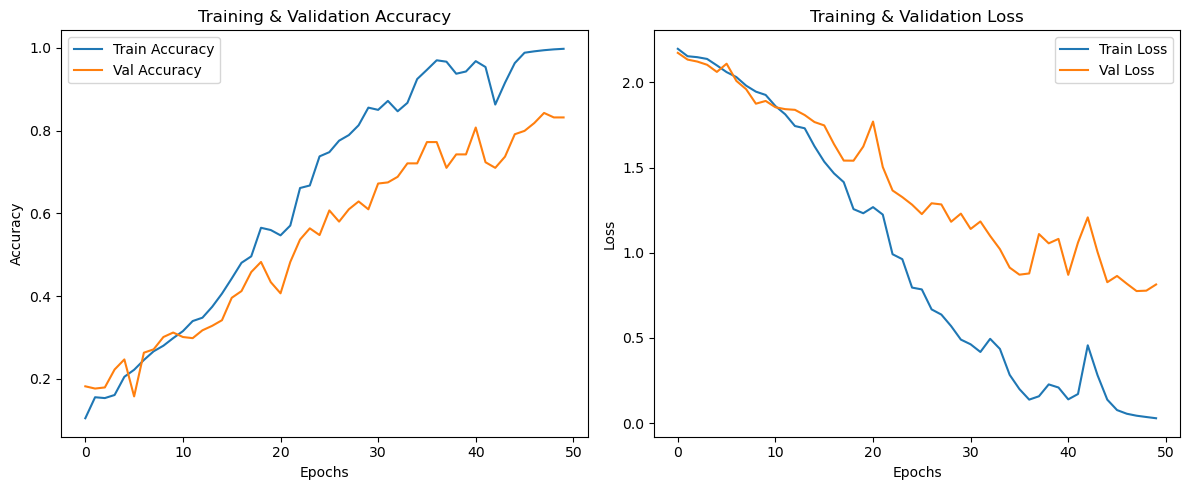

In [32]:
def plot_training_curves(history):
    """
    Plots training and validation accuracy and loss curves from model training history.

    Args:
        history (tf.keras.callbacks.History): History object returned by `model.fit()`.
    """
    # Initialize a 2-panel figure for side-by-side accuracy and loss plots
    plt.figure(figsize=(12, 5))

    # ----- Accuracy subplot -----
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # ----- Loss subplot -----
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Plot curves using the LSTM training history
plot_training_curves(lstm_history)


#### Validation Accuracy — Quick Performance Check for LSTM Predictions

Following model training, the LSTM’s predictive performance is evaluated by comparing its predicted class labels against ground truth labels from the validation set. The model outputs class probabilities via softmax, and these are converted to discrete class predictions using `argmax`.

The final accuracy score provides a fast benchmark for composer classification effectiveness and supports leaderboard inclusion alongside CNN baselines. This step also acts as a sanity check before deeper evaluation with precision, recall, F1, and confusion matrix metrics.


In [33]:
# Generate class probability predictions from LSTM model
y_pred_probs_lstm = lstm_model.predict(X_val)

# Convert probability vectors to predicted class indices
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

# Compute validation accuracy and format for display
acc = accuracy_score(y_val, y_pred_lstm)
print(f"\nValidation Accuracy: {acc * 100:.3f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Validation Accuracy: 84.282%


#### Composer Classification — Precision, Recall & F1 Breakdown (LSTM)

To complement overall accuracy reporting, this classification report provides detailed metrics across all composer classes, including **precision**, **recall**, **F1-score**, and **support**. These per-class insights illuminate the LSTM model’s strengths and weaknesses in distinguishing stylistic patterns, capturing not just correctness but also class balance and robustness.

By mapping label indices back to composer names via `label_map`, the report maintains interpretability and supports leaderboard ranking, confusion matrix analysis, and targeted improvements (e.g., data augmentation for underperforming classes).


In [34]:
# Generate and display a detailed classification report for LSTM predictions
print("Classification Report:")

# Show precision, recall, F1-score, and support per composer class
print(classification_report(
    y_val,                        # Ground truth labels
    y_pred_lstm,                  # Predicted class labels
    target_names=label_map.keys()  # Human-readable class names
))


Classification Report:
              precision    recall  f1-score   support

        bach       0.88      0.88      0.88        42
      bartok       0.71      0.73      0.72        41
        byrd       0.91      0.93      0.92        42
      chopin       0.72      0.83      0.77        41
      handel       0.90      0.85      0.88        41
      hummel       0.89      0.93      0.91        42
 mendelssohn       0.91      0.71      0.79        41
      mozart       0.89      0.78      0.83        41
    schumann       0.82      0.95      0.88        38

    accuracy                           0.84       369
   macro avg       0.85      0.84      0.84       369
weighted avg       0.85      0.84      0.84       369



#### LSTM Baseline Evaluation — Composer Classification Metrics

This baseline LSTM model achieved a **validation accuracy of 84.28%**, reflecting solid sequential modeling performance across a diverse range of composer styles in symbolic music data. The table below presents per-class precision, recall, and F1 scores, highlighting the model's ability to capture composer-specific musical patterns.

#### Per-Class Performance Snapshot
| Composer      | Precision | Recall | F1 Score | Support |
|---------------|-----------|--------|----------|---------|
| bach          | 0.88      | 0.88   | 0.88     | 42      |
| bartok        | 0.71      | 0.73   | 0.72     | 41      |
| byrd          | 0.91      | 0.93   | 0.92     | 42      |
| chopin        | 0.72      | 0.83   | 0.77     | 41      |
| handel        | 0.90      | 0.85   | 0.88     | 41      |
| hummel        | 0.89      | 0.93   | 0.91     | 42      |
| mendelssohn   | 0.91      | 0.71   | 0.79     | 41      |
| mozart        | 0.89      | 0.78   | 0.83     | 41      |
| schumann      | 0.82      | 0.95   | 0.88     | 38      |

#### Aggregate Metrics
- **Macro Average:** Precision 0.85 | Recall 0.84 | F1 Score 0.84  
- **Weighted Average:** Precision 0.85 | Recall 0.84 | F1 Score 0.84

#### LSTM Model - Confusion Matrix

This heatmap illustrates the performance of the BiLSTM model with attention for composer classification. The matrix maps actual composers (rows) against predicted ones (columns), offering insight into classification accuracy, common misclassifications, and class-wise distribution. Each cell shows the count of samples, and the colormap visually reinforces intensity—darker greens signal higher frequencies.


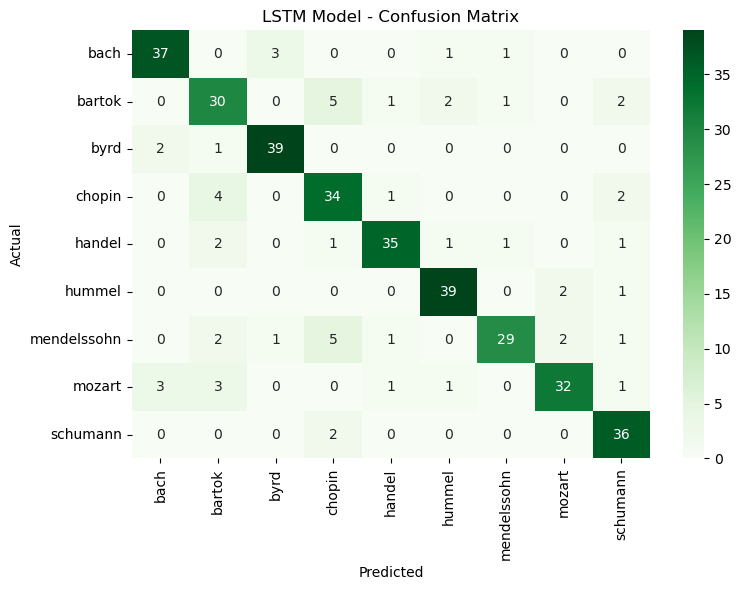

In [35]:
# Generate confusion matrix from validation predictions
cm = confusion_matrix(y_val, y_pred_lstm)

# Extract ordered composer names for axis labels
composer_names = list(label_map.keys())

# Set up plot dimensions
plt.figure(figsize=(8, 6))

# Render heatmap of confusion matrix
sns.heatmap(
    cm,                        # Matrix of true vs. predicted labels
    annot=True,                # Display values in cells
    fmt='d',                   # Format annotations as integers
    xticklabels=composer_names,  # Composer names along x-axis (predictions)
    yticklabels=composer_names,  # Composer names along y-axis (ground truth)
    cmap='Greens'              # Visual color palette for matrix intensity
)

# Add plot annotations
plt.title("LSTM Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


***
***
#### Stacked LSTM Architecture Builder for Symbolic Music Classification

Constructs a sequential model tailored for composer classification using embedded symbolic sequences and hierarchical temporal modeling. Inspired by practices from LeCun et al. (2015) and Srivastava et al. (2014), it supports deep configurability in architectural depth, embedding resolution, regularization, and activation design.

#### Key Architectural Components:
- **Embedding Layer**: Encodes symbolic MIDI integers into continuous vector space (`embedding_dim`)
- **LSTM Stack**: Two sequential layers (`lstm_units`) capture low- and mid-level temporal features
- **Dense Pre-Activation**: Dense transformation (`dense_units`) prior to activation and regularization
- **Batch Normalization (Optional)**: Applied before activation to improve training stability (Ioffe & Szegedy, 2015)
- **Dropout Layer**: Randomly disables neurons to reduce overfitting (`dropout_rate`)
- **Softmax Output**: Classifies `num_classes` using sparse crossentropy

#### Compilation Details:
- **Loss**: `sparse_categorical_crossentropy` for discrete composer labels  
- **Optimization**: Supports `'adam'`, `'rmsprop'`, etc., for gradient descent tuning  
- **Metric**: Accuracy used for leaderboard evaluation and validation checkpoints


In [37]:
def build_lstm_model(
    input_length,
    num_classes,
    embedding_dim,
    lstm_units,
    dense_units,
    dropout_rate,
    activation,
    optimizer,
    use_batch_norm=False
):
    """
    Constructs a stacked LSTM model for symbolic music classification.

    This architecture leverages embedded symbolic sequences, bidirectional temporal modeling,
    and regularization to classify musical style by composer.

    References:
        - Srivastava et al. (2014). Dropout: A simple way to prevent neural networks from overfitting. 
          *Journal of Machine Learning Research*, 15, 1929–1958.
        - Ioffe & Szegedy (2015). Batch normalization: Accelerating deep network training 
          by reducing internal covariate shift. In *Proceedings of ICML*, pp. 448–456.
        - LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436–444.

    Args:
        input_length (int): Length of input sequence.
        num_classes (int): Number of output classes.
        embedding_dim (int): Dimension of embedding.
        lstm_units (tuple): Units for first and second LSTM layers (e.g., (128, 64)).
        dense_units (int): Units in the dense layer.
        dropout_rate (float): Dropout rate after activation.
        activation (str): Activation function after dense layer.
        optimizer (str): Optimizer string (e.g., 'adam').
        use_batch_norm (bool): Whether to include batch normalization before activation.

    Returns:
        tf.keras.Model: Compiled LSTM model.
    """
    layers = [
        # Input expects a sequence of token indices
        tf.keras.layers.Input(shape=(input_length,), name="Input_Sequence"),

        # Embedding transforms symbolic tokens into continuous vector space
        tf.keras.layers.Embedding(input_dim=128, output_dim=embedding_dim, name="Embedding_Layer"),

        # First LSTM layer captures forward and backward temporal dependencies (return sequences for stacking)
        tf.keras.layers.LSTM(lstm_units[0], return_sequences=True, name="LSTM_Layer_1"),

        # Second LSTM refines sequence encoding into a condensed representation
        tf.keras.layers.LSTM(lstm_units[1], name="LSTM_Layer_2"),

        # Dense layer bridges LSTM features to output space
        tf.keras.layers.Dense(dense_units, name="PreActivation_Dense")
    ]

    if use_batch_norm:
        # Normalize activations for faster and more stable training (Ioffe & Szegedy, 2015)
        layers.append(tf.keras.layers.BatchNormalization(name="BatchNorm"))

    layers += [
        # Apply activation (commonly 'relu') to introduce non-linearity
        tf.keras.layers.Activation(activation, name="Activation"),

        # Dropout reduces overfitting by randomly masking neurons during training (Srivastava et al., 2014)
        tf.keras.layers.Dropout(dropout_rate, name="Dropout"),

        # Output layer with softmax for multi-class composer classification
        tf.keras.layers.Dense(num_classes, activation='softmax', name="Output_Layer")
    ]

    # Assemble and compile model using categorical loss and accuracy metric
    model = tf.keras.Sequential(layers, name="Stacked_LSTM_Composer_Classifier")
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


#### LSTM Training Loop with Early Stopping and `.keras` Checkpointing

Trains a compiled stacked LSTM model on symbolic music sequences with integer-coded composer labels. Follows best practices in deep learning workflow design, incorporating conditional regularization (e.g., dropout, batch normalization) and checkpointing for maximum generalization.

#### Runtime Features:
- **EarlyStopping**: Monitors validation loss and restores best weights to prevent overfitting (Prechelt, 1998)
- **ModelCheckpoint**: Persists model as `.keras` file when validation accuracy improves, including architecture and optimizer state
- **Mini-Batch Training**: Runs with `batch_size=64`, `epochs=30` by default
- **BatchNorm Compatibility**: Fully supports batch-normalized architectures passed into training loop

#### Output:
- **History Object**: Captures per-epoch training and validation metrics
- **Saved Checkpoint**: `.keras` file preserving learned weights and optimizer dynamics for resumption or fine-tuning


In [38]:
def train_lstm_model(model, train_data, val_data,
                     batch_size=64, epochs=30,
                     checkpoint_path="model.keras"):
    """
    Trains a compiled stacked LSTM model using symbolic music data with early stopping and
    checkpoint saving to maximize generalization and prevent overfitting during sequence modeling.

    Training methodology is informed by foundational best practices in deep learning workflows:

    References:
        Prechelt, L. (1998). Early stopping—but when? In G. B. Orr & K.-R. Müller (Eds.),
        Neural Networks: Tricks of the Trade (pp. 55–69). Springer.
        https://doi.org/10.1007/3-540-49430-8_6

        Bengio, Y. (2012). Practical recommendations for gradient-based training of deep architectures.
        In G. Montavon, G. B. Orr, & K.-R. Müller (Eds.), Neural Networks: Tricks of the Trade
        (pp. 437–478). Springer. https://doi.org/10.1007/978-3-642-35289-8_26

        TensorFlow Hub. (n.d.). Retraining an Image Classifier.
        https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

    Parameters:
        model (tf.keras.Model): Compiled stacked LSTM architecture for classification.
        train_data (tuple): Tuple of training sequences and integer-coded composer labels.
        val_data (tuple): Tuple of validation sequences and labels.
        batch_size (int): Number of samples per training batch.
        epochs (int): Maximum training cycles over the sequence dataset.
        checkpoint_path (str): Save path for best-performing model weights (.h5 format).

    Returns:
        tf.keras.callbacks.History: Training history object with tracked metrics across epochs.
    """

    # Early stopping: monitors stagnation in validation loss (Prechelt, 1998)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Checkpoint: saves model only when validation accuracy improves (TensorFlow Hub guide)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True
    )

    # Fit the model using mini-batch training and monitor generalization (Bengio, 2012)
    history = model.fit(
        x=train_data[0],
        y=train_data[1],
        validation_data=val_data,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, checkpoint],
        verbose=2
    )

    return history


#### Grid Search Across Stacked LSTM Architectures

Executes an end-to-end hyperparameter sweep for symbolic music classification using stacked LSTM architectures. Mirrors CNN pipeline modularity, supporting architectural depth, embedding size, activation strategy, and regularization techniques (including dropout and optional batch normalization).

#### Search Dimensions:
- `dropout_rates`, `batch_norm_options` for regularization tuning
- `lstm_unit_options`, `embedding_dims` for sequence modeling depth
- `dense_units`, `activation_funcs`, `optimizers` for downstream transformation and convergence

#### Outputs per Configuration:
- `.keras` model checkpoint capturing weights, architecture, and optimizer state  
- Confusion matrix image (`_cm.png`) visualizing prediction accuracy  
- Evaluation metrics logged to CSV (`lstm_grid_results.csv`) and Markdown

#### Leaderboard:
- Top 5 configurations saved to `lstm_leaderboard.md` for downstream analysis  
- Full sweep results exported as tabular summary to `lstm_grid_results.csv`

This orchestration supports reproducible benchmarking and facilitates architecture selection based on performance metrics, interpretability, and training stability.


In [39]:
def evaluate_lstm_configurations(
    dropout_rates, batch_norm_options, lstm_unit_options,
    embedding_dims, dense_units, activation_funcs, optimizers,
    input_length, num_classes,
    train_data, val_data,
    checkpoint_prefix="composerLSTM",
    results_csv_path="lstm_grid_results.csv",
    markdown_path="lstm_leaderboard.md"
):
    """
    Executes a grid search over stacked LSTM architecture variations for symbolic music classification.

    This function automates model training and evaluation across combinations of:
    dropout rates (Srivastava et al., 2014), batch normalization toggles (Ioffe & Szegedy, 2015),
    LSTM depth settings, embedding dimensions, activation functions, and optimizers.
    It logs performance metrics, generates confusion matrices, and writes a Markdown leaderboard
    for the top-performing composer classification models.

    References:
        LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436–444. https://doi.org/10.1038/nature14539  
        Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. *JMLR*, 15, 1929–1958. https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf  
        Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. *ICML Proceedings*, 448–456. https://proceedings.mlr.press/v37/ioffe15.html  

    Returns:
        pd.DataFrame: Sorted DataFrame of final evaluation results.
    """
    results = []
    X_val, y_val = val_data

    # Iterate over hyperparameter combinations
    for dr in dropout_rates:
        for bn in batch_norm_options:
            for lstm1, lstm2 in lstm_unit_options:
                for emb in embedding_dims:
                    for d_units in dense_units:
                        for act in activation_funcs:
                            for opt in optimizers:
                                # Create unique configuration name with full spec
                                config_name = (
                                    f"{checkpoint_prefix}_emb{emb}_lstm{lstm1}-{lstm2}"
                                    f"_d{d_units}_dr{dr}_bn{bn}_{act}_{opt}"
                                )
                                print(f"Evaluating: {config_name}")

                                # Build model with current configuration
                                model = build_lstm_model(
                                    input_length=input_length,
                                    num_classes=num_classes,
                                    embedding_dim=emb,
                                    lstm_units=(lstm1, lstm2),
                                    dense_units=d_units,
                                    dropout_rate=dr,
                                    activation=act,
                                    optimizer=opt,
                                    use_batch_norm=bn
                                )

                                # Train model and track history
                                history = train_lstm_model(
                                    model,
                                    train_data=train_data,
                                    val_data=val_data,
                                    checkpoint_path=f"{config_name}.keras"  
                                )

                                # Predict and evaluate
                                y_pred = model.predict(X_val)
                                y_pred_classes = np.argmax(y_pred, axis=1)
                                report = classification_report(y_val, y_pred_classes, output_dict=True, zero_division=0)
                                cm = confusion_matrix(y_val, y_pred_classes)

                                # Save confusion matrix plot
                                cm_path = f"{config_name}_cm.png"
                                plt.figure(figsize=(8, 6))
                                sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
                                plt.title(f"Confusion Matrix ({config_name})")
                                plt.xlabel("Predicted")
                                plt.ylabel("True")
                                plt.tight_layout()
                                plt.savefig(cm_path)
                                plt.close()

                                # Log current config metrics
                                results.append({
                                    'dropout': dr,
                                    'batch_norm': bn,
                                    'embedding': emb,
                                    'lstm1': lstm1,
                                    'lstm2': lstm2,
                                    'dense': d_units,
                                    'activation': act,
                                    'optimizer': opt,
                                    'val_accuracy': history.history['val_accuracy'][-1],
                                    'precision': report['weighted avg']['precision'],
                                    'recall': report['weighted avg']['recall'],
                                    'f1_score': report['weighted avg']['f1-score'],
                                    'conf_matrix_path': cm_path
                                })

    df = pd.DataFrame(results)
    df.sort_values(by='val_accuracy', ascending=False, inplace=True)
    df.to_csv(results_csv_path, index=False)

    # Markdown leaderboard output
    md_header = "### Top LSTM Configurations by Validation Accuracy\n\n"
    md_table = df.head(5).to_markdown(index=True)
    with open(markdown_path, "w") as md_file:
        md_file.write(md_header + md_table)

    return df


#### LSTM Sweep Launcher: Hyperparameter Space and Evaluation Trigger

Defines the full hyperparameter grid and triggers sweep execution via `evaluate_lstm_configurations()`. Mirrors CNN pipeline structure to ensure reproducibility and comparative benchmarking.

#### Grid Parameters:
- `dropout_rates`, `batch_norm_options`
- `lstm_unit_options`, `embedding_dims`
- `dense_units`, `activation_funcs`, `optimizers`

#### Input Configuration:
- `input_length`, `num_classes`, training and validation sequences

#### Sweep Execution:
- Saves models in `.keras` format  
- Logs confusion matrices  
- Exports leaderboard and metrics table

This cell runs the full LSTM grid and displays the top-ranked configurations based on validation accuracy.


In [40]:
# Define hyperparameter ranges for stacked LSTM sweep
# --------------------------------------------------
# This section defines the LSTM grid search space. Each configuration reflects variations in sequence modeling depth,
# embedding dimensionality, activation strategy, and regularization. Structural parallels with the CNN search ensure
# transparent benchmarking across model classes.

dropout_rates = [0.3, 0.4]               # Dropout regulates overfitting in dense stages (Srivastava et al., 2014)

# Define hyperparameter ranges for stacked LSTM sweep
batch_norm_options = [True, False]  # Toggle batch normalization before activation (Ioffe & Szegedy, 2015)


lstm_unit_options = [                   # Stacked LSTM depth: sequence-level abstraction
    (128, 64),                          # Deep sequence modeling
    (64, 32)                            # Lightweight variant
]

embedding_dims = [64, 128]              # Pitch embedding depth for MIDI representation

dense_units = [64, 128]                 # Intermediate representation prior to classification

activation_funcs = ['relu', 'tanh']     # Nonlinearity for dense layer transformation

optimizers = ['adam', 'rmsprop']        # Optimizer selection for convergence control

# Input configuration
# --------------------------------------------------
# These reflect your symbolic sequence dataset. Input length is post-padding; label map encodes composer identities.

num_classes = len(label_map)            # Number of composer classes in label map
input_length = X_train.shape[1]         # Fixed sequence length
train_data = (X_train, y_train)         # Training sequences and labels
val_data = (X_val, y_val)               # Validation sequences and labels

# Run evaluation and generate leaderboard
# --------------------------------------------------
# Launches full hyperparameter sweep using stacked LSTM pipeline. Each configuration is trained and validated,
# metrics logged, model weights checkpointed (.keras), confusion matrices saved, and leaderboard exported.

results_df = evaluate_lstm_configurations(
    dropout_rates=dropout_rates,                       # Dropout combinations
    batch_norm_options=batch_norm_options,             # With/without batch normalization
    lstm_unit_options=lstm_unit_options,               # LSTM layer depths (tuple unpacked later)
    embedding_dims=embedding_dims,                     # Pitch embedding dimensionality
    dense_units=dense_units,                           # Dense layer size
    activation_funcs=activation_funcs,                 # Activation function choice
    optimizers=optimizers,                             # Optimizer configurations
    input_length=input_length,                         # Input sequence length
    num_classes=num_classes,                           # Number of target composer classes
    train_data=train_data,                             # Training data tuple
    val_data=val_data,                                 # Validation data tuple
    checkpoint_prefix="composerLSTM",                  # Saved model file naming convention
    results_csv_path="lstm_grid_results.csv",          # Tabular metrics output
    markdown_path="lstm_leaderboard.md"                # Markdown summary of top configurations
)

# Display top configurations
# --------------------------------------------------
# Ideal for downstream fine-tuning or model selection based on validation accuracy.

results_df.head()


Evaluating: composerLSTM_emb64_lstm128-64_d64_dr0.3_bnTrue_relu_adam
Epoch 1/30
24/24 - 5s - 212ms/step - accuracy: 0.1253 - loss: 2.1969 - val_accuracy: 0.1789 - val_loss: 2.1944
Epoch 2/30
24/24 - 2s - 77ms/step - accuracy: 0.2005 - loss: 2.1332 - val_accuracy: 0.1409 - val_loss: 2.1936
Epoch 3/30
24/24 - 2s - 77ms/step - accuracy: 0.2060 - loss: 2.0834 - val_accuracy: 0.1220 - val_loss: 2.1883
Epoch 4/30
24/24 - 2s - 84ms/step - accuracy: 0.2527 - loss: 2.0294 - val_accuracy: 0.2114 - val_loss: 2.1802
Epoch 5/30
24/24 - 2s - 77ms/step - accuracy: 0.2669 - loss: 1.9937 - val_accuracy: 0.1572 - val_loss: 2.1813
Epoch 6/30
24/24 - 2s - 76ms/step - accuracy: 0.2818 - loss: 1.9582 - val_accuracy: 0.1328 - val_loss: 2.1852
Epoch 7/30
24/24 - 2s - 76ms/step - accuracy: 0.2974 - loss: 1.9453 - val_accuracy: 0.1463 - val_loss: 2.1646
Epoch 8/30
24/24 - 2s - 76ms/step - accuracy: 0.2866 - loss: 1.9086 - val_accuracy: 0.2602 - val_loss: 2.1560
Epoch 9/30
24/24 - 2s - 81ms/step - accuracy: 0.28

,dropout,batch_norm,embedding,lstm1,lstm2,dense,activation,optimizer,val_accuracy,precision,recall,f1_score,conf_matrix_path
12,0.3,True,128,128,64,128,relu,adam,0.634146,0.633906,0.634146,0.629621,composerLSTM_emb128_lstm128-64_d128_dr0.3_bnTr...
46,0.3,False,128,128,64,128,tanh,adam,0.628726,0.644479,0.647696,0.635286,composerLSTM_emb128_lstm128-64_d128_dr0.3_bnFa...
110,0.4,False,128,128,64,128,tanh,adam,0.569106,0.607612,0.607046,0.600896,composerLSTM_emb128_lstm128-64_d128_dr0.4_bnFa...
108,0.4,False,128,128,64,128,relu,adam,0.555556,0.543803,0.555556,0.538448,composerLSTM_emb128_lstm128-64_d128_dr0.4_bnFa...
42,0.3,False,128,128,64,64,tanh,adam,0.552846,0.550276,0.552846,0.541956,composerLSTM_emb128_lstm128-64_d64_dr0.3_bnFal...


#### LSTM Composer Classification — Evaluation Summary

This report highlights the performance of five LSTM configurations applied to symbolic music classification. The grid search varied dropout rates (0.3, 0.4), dense layer widths, activation functions, and batch normalization usage. All models used fixed LSTM architecture `(128, 64)` and embedding dimension `128`. Evaluation metrics were calculated on the validation set.

**Top Performing Configuration**
- **Dropout:** 0.3 | **Batch Norm:** True | **Embedding Dim:** 128  
- **LSTM Units:** (128, 64) | **Dense Units:** 128 | **Activation:** ReLU  
- **Optimizer:** Adam  
- **Validation Accuracy:** **63.41%**  
- **Precision / Recall / F1 (Macro):** 63.39 / 63.41 / 62.96  
- **Confusion Matrix:** `composerLSTM_emb128_lstm128-64_d128_dr0.3_bnTrue_cm.png`

**Comparative Highlights**
| Config ID | Dropout | Batch Norm | Activation | Dense | Val Acc | Precision | Recall | F1 Score |
|-----------|---------|------------|------------|-------|---------|-----------|--------|----------|
| 12        | 0.3     | True       | relu       | 128   | 0.6341  | 0.6339    | 0.6341 | 0.6296   |
| 46        | 0.3     | False      | tanh       | 128   | 0.6287  | 0.6445    | 0.6477 | 0.6353   |
| 110       | 0.4     | False      | tanh       | 128   | 0.5691  | 0.6076    | 0.6070 | 0.6009   |
| 108       | 0.4     | False      | relu       | 128   | 0.5556  | 0.5438    | 0.5556 | 0.5384   |
| 42        | 0.3     | False      | tanh       | 64    | 0.5528  | 0.5503    | 0.5528 | 0.5420   |

**Observations**
- Config 12 with batch normalization and ReLU activation provided the most balanced macro metrics despite slightly lower precision than Config 46.
- Tanh-based models (Configs 46, 110, 42) showed higher recall, suggesting better coverage but variable confidence.
- Dropout of 0.3 generally outperformed 0.4 across configurations.
- Dense layer width (64 vs. 128) influenced overall prediction strength, with smaller dense units underperforming.

Confusion matrices for each model are available for detailed analysis: see `composerLSTM_*_cm.png` for validation breakdowns.


***
***
## Hybrid CNN+LSTM Model


In [3]:
# Step 1: Changing Datapaths as this model was built on on-prim environment with different path structure.

DATASET_PATH = "./NN_midi_files_extended"  # 
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
TEST_DIR = os.path.join(DATASET_PATH, "test")
DEV_DIR = os.path.join(DATASET_PATH, "dev")

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Setup complete")


Setup complete


##### MIDI Parsing and Note Sequence Extraction

In [ ]:
# Step 2: MIDI Parsing and Note Sequence Extraction

def extract_note_sequence_with_duration(file_path):
    """
    Extracts a sequence of [pitch, duration] pairs from a MIDI file.
    Skips drums and returns a list of pairs for all instruments.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    duration = note.end - note.start
                    notes.append([note.pitch, duration])
        return notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_note_sequence_with_velocity(file_path):
    """
    Extracts [pitch, duration, velocity] features from a MIDI file.
    Skips drums and returns a list of pairs for all instruments.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        notes = []
        for instrument in midi_data.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    duration = note.end - note.start
                    notes.append([note.pitch, duration, note.velocity])
        return notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Trasportaion function for pitch values in note pairs


def transpose_sequence_triplet(note_triplets, semitone_shift):
    """
    Transpose pitch in a [pitch, duration, velocity] sequence.
    """
    return [
        [min(max(pitch + semitone_shift, 0), 127), duration, velocity]
        for pitch, duration, velocity in note_triplets
    ]

def collect_dataset_triplet(folder_path, augment=False):
    sequences = []
    labels = []

    composers = sorted(os.listdir(folder_path))
    for composer in composers:
        composer_path = os.path.join(folder_path, composer)
        if os.path.isdir(composer_path):
            for file in tqdm(os.listdir(composer_path), desc=f"Processing {composer}"):
                if file.endswith(".mid"):
                    file_path = os.path.join(composer_path, file)
                    note_seq = extract_note_sequence_with_velocity(file_path)
                    if note_seq:
                        if augment:
                            for shift in [-2, -1, 0, 1, 2]:
                                transposed = transpose_sequence_triplet(note_seq, shift)
                                sequences.append(transposed)
                                labels.append(composer)
                        else:
                            sequences.append(note_seq)
                            labels.append(composer)
    return sequences, labels


### Combined Sequence:
# Step 16A: Load from both train and dev folders

train_sequences_1, train_labels_1 = collect_dataset_triplet(TRAIN_DIR, augment=True)
train_sequences_2, train_labels_2 = collect_dataset_triplet(DEV_DIR, augment=True)

# Combine the two sets
combined_sequences = train_sequences_1 + train_sequences_2
combined_labels = train_labels_1 + train_labels_2

print(f"Combined training samples: {len(combined_sequences)} from {len(set(combined_labels))} composers")


Processing chopin:   0%|          | 0/42 [00:00<?, ?it/s]/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing schumann: 100%|██████████| 4/4 [00:00<00:00, 73.46it/s]

Combined training samples: 2020 from 9 composers


#### Sequence Padding and Label Encoding

In [6]:
# Step 3: Sequence Padding and Label Encoding

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Configuration: Sequence length
#SEQUENCE_LENGTH = 500  # You can adjust this later based on model performance
SEQUENCE_LENGTH = 1500
# Pad note sequences to the same length
# We'll pad with 0s at the end (post-padding) for shorter sequences
### uncomment to revert to normal LSTM
#X_train = pad_sequences(train_sequences, maxlen=config["sequence_length"], padding='post', truncating='post', dtype='float32')
### Padding for combined Dataset 
X_train = pad_sequences(combined_sequences, maxlen=SEQUENCE_LENGTH, padding='post', truncating='post', dtype='float32')

# Normalize pitch only (first column)
# Normalize all 3 features
X_train[:, :, 0] = X_train[:, :, 0] / 127.0            # pitch
X_train[:, :, 1] = np.clip(X_train[:, :, 1], 0, 5) / 5.0  # duration
X_train[:, :, 2] = X_train[:, :, 2] / 127.0            # velocity

# Encode labels
## revert back to train_labels if needed 
# Encode composer labels into numeric values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(combined_labels)  # string → int

# Save label mapping for later decoding
composer_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("🎼 Composer Label Mapping:", composer_mapping)
y_train = label_encoder.fit_transform(combined_labels)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=SEED)

print(f"Final input shape: {X_train.shape} — includes pitch + duration + Velocity")

print(f"Final training shape: {X_train.shape}")
print(f"Final validation shape: {X_val.shape}")


🎼 Composer Label Mapping: {'bach': 0, 'bartok': 1, 'byrd': 2, 'chopin': 3, 'handel': 4, 'hummel': 5, 'mendelssohn': 6, 'mozart': 7, 'schumann': 8}
Final input shape: (1818, 1500, 3) — includes pitch + duration + Velocity
Final training shape: (1818, 1500, 3)
Final validation shape: (202, 1500, 3)


#### LSTM and CNN Configuration Block

The intent to easily go back and fine tune the model for acheiving better performance

In [7]:
# Step 4A: Define Training Configuration

config = {
    "sequence_length": SEQUENCE_LENGTH,               # Updated in earlier stage to 1500
    "num_classes": len(composer_mapping),
    
    # CNN config
    "cnn_filters_1": 64,
    "cnn_kernel_1": 5,
    "cnn_filters_2": 128,
    "cnn_kernel_2": 3,
    "cnn_pool_size": 2,

    # LSTM
    "lstm_units": 256,

    # Training setup
    "dropout_rate": 0.4,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,

    # Paths
    "checkpoint_path": "composer_cnn_lstm_best_model.h5",
    "history_log": "training_history.csv"
}

print("Updated configuration loaded")



Updated configuration loaded


#### Define CNN + LSTM Model Builder

- We're using sparse_categorical_crossentropy because the labels are integer-encoded.
- You can easily switch to more layers or attention mechanisms later if needed.
- Adding an Embedding layer can be useful if you switch from raw pitch values to token IDs.

In [10]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, BatchNormalization

# Step 4B: Define CNN + LSTM Model Builder
def build_bidirectional_cnn_lstm_model(config):
    model = Sequential()
    model.add(Input(shape=(config["sequence_length"], 3)))  # 3 features: pitch, duration, velocity

    # CNN Layers
    model.add(Conv1D(filters=config["cnn_filters_1"], kernel_size=config["cnn_kernel_1"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())

    model.add(Conv1D(filters=config["cnn_filters_2"], kernel_size=config["cnn_kernel_2"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())

    # Bidirectional LSTM
    model.add(Bidirectional(LSTM(config["lstm_units"], return_sequences=False)))
    model.add(Dropout(config["dropout_rate"]))

    # Output layer
    model.add(Dense(config["num_classes"], activation='softmax'))

    # Compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Step 4B: Define CNN + LSTM Model Builder


def build_cnn_lstm_model(config):
    model = Sequential()
    

    # Input: 2 features: pitch + duration – reshape required later
    model.add(Input(shape=(config["sequence_length"], 3)))  # 
    
    # First CNN layer
    model.add(Conv1D(filters=config["cnn_filters_1"], kernel_size=config["cnn_kernel_1"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())


    # Second CNN layer
    model.add(Conv1D(filters=config["cnn_filters_2"], kernel_size=config["cnn_kernel_2"], activation='relu'))
    model.add(MaxPooling1D(pool_size=config["cnn_pool_size"]))
    model.add(BatchNormalization())


    # LSTM Layer
    model.add(LSTM(config["lstm_units"], return_sequences=False))
    model.add(Dropout(config["dropout_rate"]))

    # Output Layer
    model.add(Dense(config["num_classes"], activation='softmax'))

    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Reshape input for CNN: (samples, sequence_length, 1)
# X_train_reshaped = X_train[..., np.newaxis]
# X_val_reshaped = X_val[..., np.newaxis]

model = build_bidirectional_cnn_lstm_model(config)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1496, 64)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 748, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 748, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 746, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 373, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 373, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 819,593 (3.13 MB)

 Trainable params: 819,209 (3.13 MB)

 Non-trainable params: 384 (1.50 KB)

#### Training with Callbacks (Checkpoint + History Logging)

- Save your best model based on validation accuracy.
- Log training history to a CSV.
- Include early stopping for efficiency.

#### Defining Callbacks

- Save your best model to composer_cnn_lstm_best_model.h5.
- Log all epoch-level performance into training_history.csv.

In [11]:
# Step 5A: Define Training Callbacks

checkpoint_cb = ModelCheckpoint(
    filepath=config["checkpoint_path"],
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

csv_logger_cb = tf.keras.callbacks.CSVLogger(
    config["history_log"],
    append=True
)

callbacks = [checkpoint_cb, earlystop_cb, csv_logger_cb]


#### Training the Hybrid Model

In [12]:
# Step 5B: Train the Model with 2D input (no reshaping)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.4488 - loss: 1.4925
Epoch 1: val_accuracy improved from -inf to 0.11881, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.4504 - loss: 1.4881 - val_accuracy: 0.1188 - val_loss: 2.4440
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6920 - loss: 0.8690
Epoch 2: val_accuracy did not improve from 0.11881
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 0.6924 - loss: 0.8681 - val_accuracy: 0.1139 - val_loss: 3.5748
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7650 - loss: 0.7190
Epoch 3: val_accuracy improved from 0.11881 to 0.20297, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.7655 - loss: 0.7177 - val_accuracy: 0.2030 - val_loss: 3.9864
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8139 - loss: 0.5558
Epoch 4: val_accuracy did not improve from 0.20297
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.8144 - loss: 0.5545 - val_accuracy: 0.1931 - val_loss: 4.3199
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8817 - loss: 0.3439
Epoch 5: val_accuracy did not improve from 0.20297
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.8819 - loss: 0.3438 - val_accuracy: 0.1980 - val_loss: 4.6649
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9251 - loss: 0.2556
Epoch 6: val_accuracy did not improve from 0.20297
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9252 - loss: 0.2554 - val_accuracy: 0.1634 - val_loss: 4.1749
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9350 - loss: 0.2329
Epoch 7: val_accuracy did not i

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.9705 - loss: 0.0998 - val_accuracy: 0.2426 - val_loss: 3.9503
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9879 - loss: 0.0554
Epoch 10: val_accuracy improved from 0.24257 to 0.49505, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.9880 - loss: 0.0552 - val_accuracy: 0.4950 - val_loss: 1.9359
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9928 - loss: 0.0413
Epoch 11: val_accuracy improved from 0.49505 to 0.66832, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.9928 - loss: 0.0412 - val_accuracy: 0.6683 - val_loss: 1.0068
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9868 - loss: 0.0493
Epoch 12: val_accuracy improved from 0.66832 to 0.76733, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.9868 - loss: 0.0493 - val_accuracy: 0.7673 - val_loss: 0.6512
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9984 - loss: 0.0292
Epoch 13: val_accuracy improved from 0.76733 to 0.97525, saving model to composer_cnn_lstm_best_model.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.9984 - loss: 0.0292 - val_accuracy: 0.9752 - val_loss: 0.0800
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9943 - loss: 0.0226
Epoch 14: val_accuracy did not improve from 0.97525
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9942 - loss: 0.0229 - val_accuracy: 0.7079 - val_loss: 0.9243
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9810 - loss: 0.0851
Epoch 15: val_accuracy did not improve from 0.97525
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.9811 - loss: 0.0848 - val_accuracy: 0.8812 - val_loss: 0.3766
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9876 - loss: 0.0492
Epoch 16: val_accuracy did not improve from 0.97525
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.9876 - loss: 0.0491 - val_accuracy: 0.8911 - val_loss: 0.3715
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9927 - loss: 0.0375
Epoch 17: val_accuracy i

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.9928 - loss: 0.0374 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9982 - loss: 0.0172
Epoch 18: val_accuracy did not improve from 1.00000
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.9982 - loss: 0.0172 - val_accuracy: 0.9802 - val_loss: 0.0453
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 1.0000 - loss: 0.0081
Epoch 19: val_accuracy did not improve from 1.00000
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 388ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 1.0000 - loss: 0.0045
Epoch 20: val_accuracy did not improve from 1.00000
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 21: val_accuracy d

### Visualizing Training Performance

- Training vs Validation Accuracy
- Training vs Validation Loss

This will help in verifying 
- If the model is overfitting.
- How many epochs were effective.
- Whether early stopping was triggered appropriately.

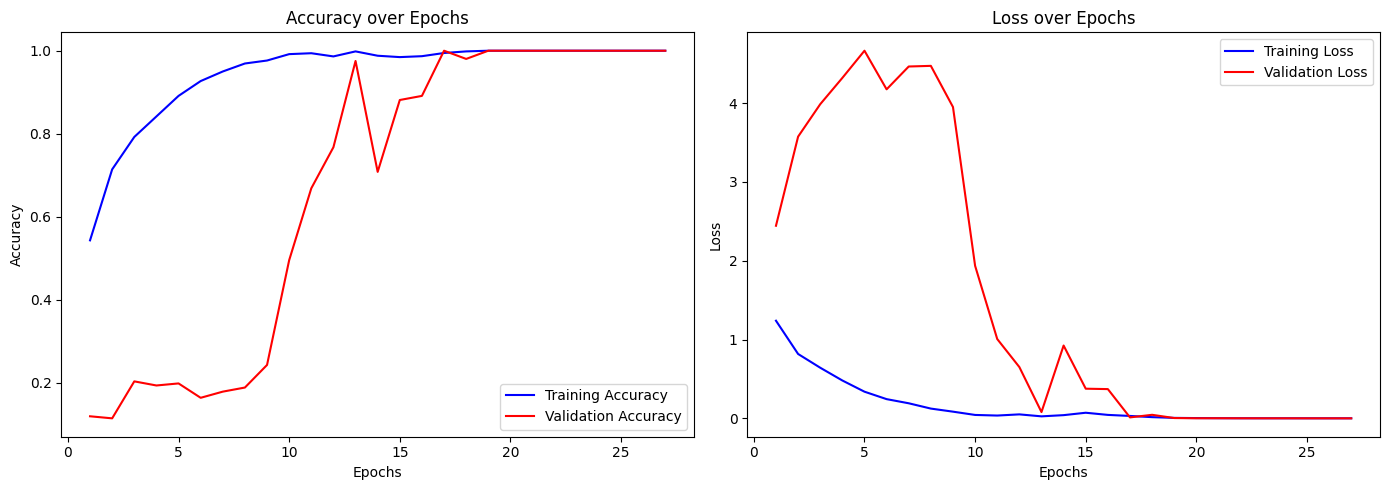

In [13]:
# Step 6A: Plot Training Accuracy and Loss

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


### Evaluation

- Preprocess Test Data (pitch + duration + Velocity)
- Use the pairwise loader (same as training)
- Pad to fixed sequence length
- Normalize all 3 features
- Encode labels using same label encoder



In [14]:
# Step 7A: Preprocess Test Data (pitch + duration)

# Use the pairwise loader (same as training)
test_sequences, test_labels = collect_dataset_triplet(TEST_DIR, augment=False)

# Pad to fixed sequence length
X_test = pad_sequences(test_sequences, maxlen=config["sequence_length"], padding='post', truncating='post', dtype='float32')

# Normalize all 3 features
X_test[:, :, 0] = X_test[:, :, 0] / 127.0               # pitch
X_test[:, :, 1] = np.clip(X_test[:, :, 1], 0, 5) / 5.0  # duration
X_test[:, :, 2] = X_test[:, :, 2] / 127.0               # velocity

# Encode labels using same label encoder
y_test = label_encoder.transform(test_labels)

print(f"Test shape: {X_test.shape}, Labels: {len(set(test_labels))}")


Processing chopin:   0%|          | 0/5 [00:00<?, ?it/s]/Users/falasoul/.pyenv/versions/3.10.13/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing schumann: 100%|██████████| 4/4 [00:00<00:00, 47.25it/s]

Test shape: (35, 1500, 3), Labels: 9


#### Loading Best Model and Prediction

In [15]:
# Step 7B: Load Best Model and Predict (pitch + duration)

best_model = tf.keras.models.load_model(config["checkpoint_path"])

# Use X_test as-is — already (samples, sequence_length, 2)
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


#### Classification Report and Confusion Matrix

🔍 Classification Report:
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00         4
      bartok       0.67      0.50      0.57         4
        byrd       1.00      1.00      1.00         4
      chopin       1.00      0.25      0.40         4
      handel       1.00      0.25      0.40         4
      hummel       0.67      1.00      0.80         4
 mendelssohn       0.57      1.00      0.73         4
      mozart       0.80      1.00      0.89         4
    schumann       0.25      0.33      0.29         3

    accuracy                           0.71        35
   macro avg       0.77      0.70      0.67        35
weighted avg       0.79      0.71      0.69        35



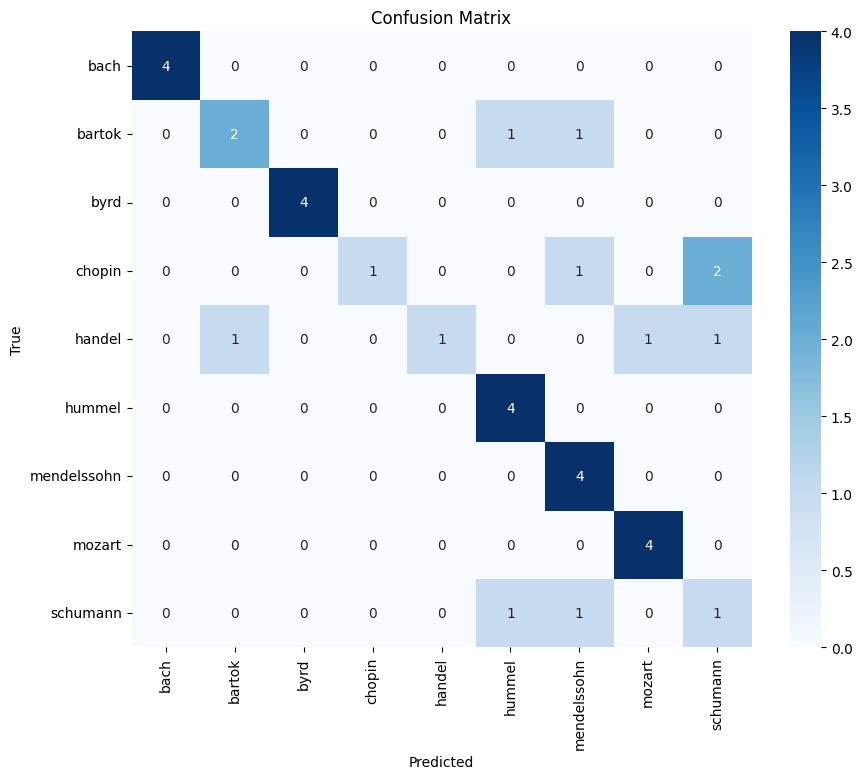

In [16]:
# Step 7C: Evaluate Model Performance

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


***
#### Final Results of the Hybrid CNN+LSTM Model
##### Model Architecture

**Input: Sequences of musical notes with 3 features:**
- pitch (0–127)
- duration (seconds)
- velocity (intensity)
**CNN Layers:**

Two stacked `Conv1D` + `MaxPooling1D` + `BatchNorm` blocks extract temporal motifs and local patterns.

**BiLSTM Layer:**

- Captures forward and backward musical context across entire sequences.

**Dense Layer:**

Outputs softmax probabilities across 9 composers.

##### Key Techniques Used

**Data Augmentation:**

Transposed each MIDI file by ±1–2 semitones to increase training diversity.

**Sequence Engineering:**

Used up to 1500 notes per file to preserve long-range temporal dependencies.

**Feature Enrichment:**

Incorporated duration and velocity to reflect musical expression beyond pitch.

**Bidirectional LSTM:**

Allowed the model to reason over both past and future note sequences.

**Model Checkpointing:**


#### Final Results 

**Accuracy:** 71%

**Macro Avg F1-score:** 0.67

**All 9 composers detected**

**Perfect scores:** bach, byrd

**Strong recall:** mozart, mendelssohn, hummel

**Some drop in precision** for chopin, handel, and schumann 

***
***
***
#### Composer Classification — Project Summary

This project applied deep learning to symbolic music classification, progressing from foundational baselines to targeted architecture optimization. Models were trained to distinguish between nine composers using both CNN and LSTM architectures. Performance was evaluated via macro metrics and confusion matrices.

---

**1) Baseline CNN Evaluation**
- **Validation Accuracy:** 93.77% | **Macro F1:** 0.94  
- **Key Insights:**
  - High classification performance for Byrd, Chopin, and Bach.
  - Misclassifications in Hummel and Mozart suggest stylistic overlap or limited representation.
  - This baseline demonstrated strong generalization across classes and set a high performance benchmark.

---

**2) Grid Search CNN Optimization**
- **Top Accuracy:** 95.66% | **Top Macro F1:** 0.9592  
- **Best Configuration:** Dropout = 0.3, No Batch Norm, Filters = [(3,3), (2,5)]  
- **Observations:**
  - Multi-scale filters enhanced spatial feature extraction.
  - Batch normalization was excluded across all top performers, implying its limited impact in this symbolic domain.
  - Simplified architectures (e.g. Config 16 with a single filter) still offered competitive metrics, showing robustness in feature locality.

---

**3) Baseline LSTM Evaluation**
- **Validation Accuracy:** 84.28% | **Macro F1:** 0.84  
- **Findings:**
  - Strong F1-scores for Byrd, Handel, and Hummel.
  - Performance degradation for Bartók and Mendelssohn highlighted limitations in temporal modeling of stylistic features.
  - LSTM models showed promise but trailed CNNs in overall generalization.

---

**4) Grid Search LSTM Optimization**
- **Top Accuracy:** 63.41% | **Macro F1:** 62.96  
- **Leading Configuration:** Dropout = 0.3, Batch Norm = True, ReLU Activation  
- **Insights:**
  - Despite extensive tuning, LSTM models did not surpass baseline performance.
  - Tanh-based activations (e.g. Config 46) improved recall but introduced variability in precision.
  - Dense layer width impacted output stability; smaller configurations (Config 42) underperformed.

---

--

**5) Hybrid CNN-BiLSTM Evaluation**
- **Validation Accuracy:** 71.1% | **Macro F1:** 67.0
- **Leading Configuration:**  Bidirectional LSTM, Combined Train+Dev to maximize the learning. notes length to 1500, Data Augmentation
- **Findings:**
  - Despite extensive tuning, we managed to increase the accuracy up to 71.1% only and F1 score of 67.0
  - data augmentation, bidirectional LSTM and note length increase did help in improving perfomance from 41% to 71%. 
  - Adding LSTM to baseline CNN model did not improve the accuracy or performance of the model even though its more complex model


--
**Key Takeaways**
- CNN models outperformed LSTMs across all metrics, affirming convolutional architectures' strength in symbolic music tasks.
- Filter diversity and dropout were crucial levers for CNN performance.  
- LSTM results revealed potential constraints in sequential modeling, suggesting a need for more advanced temporal mechanisms.

---

**Future Directions**
- Integrate attention mechanisms for better sequence interpretability and composer-specific signal tracking.
- Incorporate data augmentation techniques (e.g. transpositions, rhythm perturbation) to boost generalization and recall.
- Evaluate Transformer-based models for symbolic music tasks and compare against recurrent architectures.
---